In [1]:
import pandas as pd
import os
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '../'))
sys.path.append(parent_dir)
from em_utils import * # import the utils

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/"
os.makedirs(df_dir, exist_ok=True)

print("---------- Read data ----------")
input_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/april_processing/"
long = read_data(input_dir,"long_april29.csv")
delta = read_data(input_dir, "all_delta_april29.csv")
print(long.columns.to_list)
print(delta.columns.to_list)

---------- Read data ----------
<bound method IndexOpsMixin.tolist of Index(['Unnamed: 0', 'record_id', 'time', 'subject_id', 'randomized_group',
       'consent', 'cohort_number', 'sex', 'race', 'completer',
       ...
       'Isovalerate..3.Methylbutanoate', 'phenylacetate', 'Succinate',
       'Isobutyrate..2.Methylpropanoate', 'Water', 'Hydrogen', 'Dephospho.CoA',
       'indole.3.acetate', 'Malonate', 'aldehydo.D.xylose'],
      dtype='object', length=402)>
<bound method IndexOpsMixin.tolist of Index(['Unnamed: 0', 'subject_id', 'record_id', 'time', 'randomized_group',
       'consent', 'cohort_number', 'sex', 'race', 'completer',
       ...
       'nitrate.reduction.VI..assimilatory.', 'TCA.cycle.VIII..helicobacter.',
       'L.rhamnose.degradation.I', 'formaldehyde.oxidation.I',
       'adenosine.nucleotides.degradation.II',
       'sulfate.reduction.I..assimilatory.',
       'teichoic.acid..poly.glycerol..biosynthesis',
       'superpathway.of.thiamin.diphosphate.biosynthesis.I

In [3]:
print(long.columns.to_list()) 
print(delta.columns.to_list()) 

['Unnamed: 0', 'record_id', 'time', 'subject_id', 'randomized_group', 'consent', 'cohort_number', 'sex', 'race', 'completer', 'outcome_BMI_fnl', 'age', 'Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'Peptide_YY', 'Ghrelin', 'Leptin', 'Hemoglobin_A1C', 'bmi_prs', 'non_HDL_C', 'Remnant_C', 'VLDL_C', 'Clinical_LDL_C', 'VLDL_TG', 'LDL_TG', 'HDL_TG', 'Total_PL', 'VLDL_PL', 'Total_CE', 'VLDL_CE', 'HDL_CE', 'Total_FC', 'LDL_FC', 'HDL_FC', 'Total_L', 'VLDL_L', 'HDL_L', 'VLDL_P', 'LDL_P', 'HDL_P', 'VLDL_size', 'LDL_size', 'HDL_size', 'TG_by_PG', 'Cholines', 'Phosphatidylc', 'Sphingomyelins', 'ApoB_by_ApoA1', 'Total_FA', 'Unsaturation', 'Omega_3', 'Omega_6', 'MUFA', 'SFA', 'LA', 'DHA', 'Omega_3_pct', 'Omega_6_pct', 'PUFA_pct', 'MUFA_pct', 'SFA_pct', 'LA_pct', 'DHA_pct', 'PUFA_by_MUFA', 'Omega_6_by_Omega_3', 'Ala', 'Gln', 'Gly', 'His', 'Total_BCAA', 'Ile', 'Leu', 'Val', 'Phe', 'Tyr', 'Glucose.y', 'Lactate', 'Pyruvate', 'Citrate', 'Glycero

In [4]:
columns_to_drop = ['Peptide_YY', 'Ghrelin', 'Leptin', 'completer', 'consent', 'Hemoglobin_A1C', 'record_id']
long = long.drop([col for col in columns_to_drop if col in long.columns], axis=1)
print(long.columns.to_list)
#Make time numeric 
time_mapping = {
    "BL": 0,
    "6m": 6,
    "12m": 12
}
long['time'] = long['time'].replace(time_mapping)
print(long['time'])

<bound method IndexOpsMixin.tolist of Index(['Unnamed: 0', 'time', 'subject_id', 'randomized_group', 'cohort_number',
       'sex', 'race', 'outcome_BMI_fnl', 'age', 'Glucose.x',
       ...
       'Isovalerate..3.Methylbutanoate', 'phenylacetate', 'Succinate',
       'Isobutyrate..2.Methylpropanoate', 'Water', 'Hydrogen', 'Dephospho.CoA',
       'indole.3.acetate', 'Malonate', 'aldehydo.D.xylose'],
      dtype='object', length=395)>
0       0
1       0
2       0
3       0
4       0
       ..
383    12
384    12
385    12
386    12
387    12
Name: time, Length: 388, dtype: int64


'time', 'subject_id.x', 'randomized_group', 'cohort_number', 'sex', 'race', 'subject_id.y', 'outcome_BMI_fnl', 'age', 'Glucose', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'bmi_prs', 'g__Coprenecus', 

In [5]:
BMI_VAR, ID_VAR, TIME_VAR, DATA = 'outcome_BMI_fnl', 'subject_id', 'time', long
# Specify columns for long
#basic = [BMI_VAR, ID_VAR, TIME_VAR, 'age','sex']
#meta_keep = [BMI_VAR, ID_VAR, TIME_VAR, 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid']
#only_grs = [BMI_VAR, ID_VAR, TIME_VAR, 'bmi_prs']
#only_taxa = [BMI_VAR, ID_VAR, TIME_VAR] + [col for col in DATA.columns if col.startswith("g__")]
#proton_column = DATA.columns.get_loc("proton")
#carbon_dioxide_column = DATA.columns.get_loc("Carbon.dioxide")
#only_micom = [BMI_VAR, ID_VAR, TIME_VAR] + [col for col in DATA.columns if col in DATA.columns[proton_column:carbon_dioxide_column+1]]
# Create a set of all columns to EXCLUDE for pathway
#exclude_columns = set(meta_keep + only_grs + only_taxa + only_micom)
#only_pathway = [BMI_VAR, ID_VAR, TIME_VAR] + [col for col in DATA.columns if col not in exclude_columns]

# Define the column names based on your lists
basic = [BMI_VAR, ID_VAR, TIME_VAR, 'sex', 'age', 'randomized_group']
meta_keep = [BMI_VAR, ID_VAR, TIME_VAR, 'randomized_group', 'sex', 'race', 
             'age', 'Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid']
only_grs = [BMI_VAR, ID_VAR, TIME_VAR, 'bmi_prs']
only_taxa = [BMI_VAR, ID_VAR, TIME_VAR,] + [col for col in DATA.columns if col.startswith("g__")]

micom_start = DATA.columns.get_loc("Diacetyl")
micom_end = DATA.columns.get_loc("aldehydo.D.xylose")
only_micom = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[micom_start:micom_end + 1])

path_start = DATA.columns.get_loc("arginine..ornithine.and.proline.interconversion")
path_end = DATA.columns.get_loc("UDP.N.acetyl.D.glucosamine.biosynthesis.I")
only_pathway = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[path_start:path_end + 1])

metabo_start = DATA.columns.get_loc("non_HDL_C")
metabo_end = DATA.columns.get_loc("IDL_TG_pct")
only_metabo = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[metabo_start:metabo_end + 1])

# Define the list of columns to include
all_col = [BMI_VAR, ID_VAR, TIME_VAR,] + ['randomized_group', 'sex', 'race',
    'age','Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid'] + \
    list(DATA.columns[DATA.columns.str.startswith("g__")]) + \
    list(DATA.columns[micom_start:micom_end + 1]) + \
    list(DATA.columns[path_start:path_end + 1]) + \
    list(DATA.columns[metabo_start:metabo_end + 1])

Set up MERF testing and training splits 

In [6]:
# test sample names
#test_names = ["ABR-079", "AGA-071", "AHE-055", "ALI-121", "ALO-163", "AMA-031", "ASO-013", "AWI-167", "BMO-164", "CWA-183", "DSC-024", "EBE-130", "EHI-177", "EJO-092", "GFU-188", "HGI-010", "JCA-109", "JGO-100",
#    "KBU-085", "KCE-034", "KHE-170", "LDO-148", "LST-186", "LZD-142", "MAR-119", "MCA-088", "MJA-153", "MWE-112", "NPO-149", "RAE-114", "SBO-020", "SEG-080", "SKA-195", "SLO-178", "SSH-028", "TDU-086","TFA-016", "VCA-041"]
test_names = ["ASO-013", "NTA-021", "KGI-029", "KPA-042", "AWA-052", "AHE-055", "COW-066", "NBI-069", "CEL-073", "CAL-074", "ABR-079", "SEG-080", "NKA-090", "NEL-094", "LJA-101", "ADA-105", "MLU-106", "MDI-107", "JER-110", "TRO-113", "MFB-118", "ALI-121", "KWA-122", "RAF-125", "EBE-130", "CGA-134", "LZD-142", "NPO-149", "HDE-154", "AMC-155", "SAB-160", "QNG-166", "NCO-171", "BSA-174", "EHI-177", "LST-186", "MBA-187", "BAN-193"]
#
#train_names = ["AAL-144", "ACO-053", "ADA-105", "AKE-009", "AKI-011", "AKO-139", "AMC-155", "AME-128", "AME-157", "ATA-129", "AWA-052", "AWA-083", "BAN-193", "BHO-014", "BIN-201", "BKN-104", "BMI-156", "BSA-174", "CAM-057", "CCO-189",
#    "CED-026", "CEL-073", "CGA-134", "CIS-077", "CKR-078", "CLE-049", "COW-066", "CRO-108", "CWA-161", "EBE-051", "EKA-135", "EKR-045", "ELA-159", "EPO-182", "EVO-184", "FWI-098", "GHA-035", "HDE-154", "IBE-120", "JDI-140", "JER-110", "JFU-027", "JJO-093", "JKN-127", "JPO-022", "JUG-116", "JUT-032", "JVE-126", "KAN-138", "KBR-162", "KEL-185", "KEL-199", "KGI-029", "KHU-196", "KPA-042", "KRI-072", "KVA-038", "KWA-122", "KWA-141", "LBL-047", "LBU-015", "LEL-147", "LFI-003", "LJA-101", "LMC-111", "LPF-198", "LVA-017", "MBA-187", "MCW-065", "MDI-107", "MES-068", "MFB-118", "MGA-076", "MHO-117", "MKE-192", "MMA-036", "MRT-179", "MSH-091", "MST-039", "MWE-143",
#    "MWO-133", "MWY-152", "NAR-099", "NBI-048", "NBI-069", "NCO-171", "NDI-067", "NEL-094", "NKA-090", "NMO-151", "NTA-021", "PBE-123", "QNG-166", "RAF-125", "RAM-050", "RHP-023", "RLA-132", "ROL-006", "SAB-160", "SCA-043", "SCR-061", "SDA-150", "SGA-062", "SKA-087", "SRO-194", "TBU-115", "TFA-172", "TRO-113", "TSH-146", "TSL-056", "WPE-005", "YOR-103", "YSU-097", "ZVU-096"]
train_names = ["SDA-150", "LBU-015", "CIS-077", "ATA-129", "KHU-196", "MWY-152", "AGA-071", "AME-157", "CWA-183", "RHP-023", "MST-025", "SSH-028", "JUG-116", "EJO-092", "VCA-041", "NMO-151", "BHO-014", "KBU-085", "SBO-020", "MWO-133", "KRI-072", "AAL-144", "ALO-163", "AKI-011", "MHO-117", "TSH-146", "RAE-114", "FWI-098", "MAR-119", "JGO-100", "CAM-057", "YOR-103", "HGI-010", "KAN-138", "SGA-062", "CKR-078", "MWE-112", "ROL-006", "MMA-036", "DSC-024", "LDO-148", "MCA-088", "CPU-075", "AKO-139", "LFI-003", "KWA-141", "GFU-188", "BMO-164", "JPO-022", "EVO-184", "LPF-198", "TBU-115", "SRO-194", "KEL-199", "JFU-027", "SKA-195", "IBE-120", "TSL-056", "NDI-067", "AWA-083", "CWA-161", "TDU-086", "JCA-109", "CBO-004", "NAR-099", "MES-068", "AMA-031", "SLO-178", "SCA-043", "AWI-167",  "KBR-162", "TFA-172", "BIN-201", "NBI-048", "KHE-170", "CSH-012", "BMI-156", "MWE-143", "EKA-135", "WPE-005", "AKE-009", "YSU-097", "MCW-065", "EBE-051", "ZVU-096", "JJO-093", "KVA-038", "ACO-053", "RLA-132", "MBA-176", "CED-026", "JDI-140", "CCO-189", "EKR-045", "MJA-153", "CLE-049", "LMC-111", "SKA-087", "JUT-032", "MKE-192", "JVE-126", "KCE-034", "KEL-185", "MRT-179", "JKN-127", "LEL-147", "BKN-104", "AME-128", "MSH-091", "MGA-076", "LVA-017", "EPO-182"]

print("Length of test names:", len(test_names))
print("Length of train names:", len(train_names))

Length of test names: 38
Length of train names: 112


In [7]:
column_sets = {
    "basic": basic,
    "meta_keep": meta_keep,
    "only_grs": only_grs, 
    "only_taxa": only_taxa,
    "only_micom": only_micom,
    "only_pathway": only_pathway,
    "only_metabo" : only_metabo,
    "only_all" : all_col
}

# Initialize a list to store summary data
summary_data = []

# Loop through each column set and create DATA
for key, columns in column_sets.items():
    DATA = long[columns]
    print(f"Subset for {key} created with shape: {DATA.shape}")
    
    # Calculate summary statistics
    summary = DATA.groupby('time').agg(
    unique_id_count=(ID_VAR, 'nunique'),  # Count unique ID_VAR
    feature_count=('time', lambda x: DATA.shape[1] - 2)  # Count total features excluding 'time' and 'ID_VAR'
    ).reset_index()
    
    # Print the summary table
    print("\nSummary Table for", key)
    print(summary.to_string(index=False))  # Print without the index
    
    # Append summary to the summary_data list
    summary_data.append((key, summary))

Subset for basic created with shape: (388, 6)

Summary Table for basic
 time  unique_id_count  feature_count
    0              150              4
    6              124              4
   12              114              4
Subset for meta_keep created with shape: (388, 13)

Summary Table for meta_keep
 time  unique_id_count  feature_count
    0              150             11
    6              124             11
   12              114             11
Subset for only_grs created with shape: (388, 4)

Summary Table for only_grs
 time  unique_id_count  feature_count
    0              150              2
    6              124              2
   12              114              2
Subset for only_taxa created with shape: (388, 124)

Summary Table for only_taxa
 time  unique_id_count  feature_count
    0              150            122
    6              124            122
   12              114            122
Subset for only_micom created with shape: (388, 56)

Summary Table for only_micom
 

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 370.3260917744181 at iteration 1.


Subset for only_metabo created with shape: (388, 81)
---------- Select predictors for training set only_metabo ----------
Length of X: 300, Length of clusters_train: 300, Length of Y: 300
Final columns after drop: ['time', 'non_HDL_C', 'Remnant_C', 'VLDL_C', 'Clinical_LDL_C', 'VLDL_TG', 'LDL_TG', 'HDL_TG', 'Total_PL', 'VLDL_PL', 'Total_CE', 'VLDL_CE', 'HDL_CE', 'Total_FC', 'LDL_FC', 'HDL_FC', 'Total_L', 'VLDL_L', 'HDL_L', 'VLDL_P', 'LDL_P', 'HDL_P', 'VLDL_size', 'LDL_size', 'HDL_size', 'TG_by_PG', 'Cholines', 'Phosphatidylc', 'Sphingomyelins', 'ApoB_by_ApoA1', 'Total_FA', 'Unsaturation', 'Omega_3', 'Omega_6', 'MUFA', 'SFA', 'LA', 'DHA', 'Omega_3_pct', 'Omega_6_pct', 'PUFA_pct', 'MUFA_pct', 'SFA_pct', 'LA_pct', 'DHA_pct', 'PUFA_by_MUFA', 'Omega_6_by_Omega_3', 'Ala', 'Gln', 'Gly', 'His', 'Total_BCAA', 'Ile', 'Leu', 'Val', 'Phe', 'Tyr', 'Glucose.y', 'Lactate', 'Pyruvate', 'Citrate', 'Glycerol', 'bOHbutyrate', 'Acetate', 'Acetoacetate.x', 'Acetone', 'Creatinine', 'Albumin', 'GlycA', 'IDL_P

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 423.7086310112087 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 405.2067325657408 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.5453, prev: 0.4547, OOB Score: -142.8000
Length of clusters_train: 200
Length of clusters_test: 100
Combination, ptev: 0.5786, prev: 0.4214, OOB Score: -31.3000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 480.2488058731989 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 534.7442824909095 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6336, prev: 0.3664, OOB Score: -106.3000
Combination: (10, None, 0.05, 2, 5)

Progress: 3.70% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 498.0233417934538 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Combination, ptev: 0.5175, prev: 0.4825, OOB Score: -68.0000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 548.2697776513052 at iteration 2.


Combination, ptev: 0.5218, prev: 0.4782, OOB Score: -87.4000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 509.43046470986366 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 575.0571333300736 at iteration 2.


Combination, ptev: 0.5767, prev: 0.4233, OOB Score: -86.8000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 562.3875658467249 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 612.5602998140062 at iteration 2.


Combination, ptev: 0.6032, prev: 0.3968, OOB Score: -106.7000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 517.7234571192147 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 562.6187686117548 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6236, prev: 0.3764, OOB Score: -103.1000
Combination: (10, None, 0.05, 2, 10)

Progress: 5.56% completed

Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 577.1223785512034 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 548.4998094193179 at iteration 1.


Combination, ptev: 0.6295, prev: 0.3705, OOB Score: -177.6000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 603.6540412596645 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 594.0533516083066 at iteration 1.


Combination, ptev: 0.6006, prev: 0.3994, OOB Score: -21.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 630.1750580147975 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 546.0094846023079 at iteration 1.


Combination, ptev: 0.6040, prev: 0.3960, OOB Score: -80.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 606.2310043705565 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 598.6930726973522 at iteration 1.


Combination, ptev: 0.5903, prev: 0.4097, OOB Score: 1.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 643.6193173096138 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 541.2442794269939 at iteration 1.


Combination, ptev: 0.6144, prev: 0.3856, OOB Score: -70.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 605.2954264644077 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 597.6020064241828 at iteration 1.


Combination, ptev: 0.6264, prev: 0.3736, OOB Score: -125.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 606.358250331275 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 582.5209393160093 at iteration 1.


Combination, ptev: 0.6363, prev: 0.3637, OOB Score: 3.6000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 647.1050294644709 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 581.2096334112031 at iteration 1.


Combination, ptev: 0.6359, prev: 0.3641, OOB Score: -12.2000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 670.045570460489 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 576.6494972761203 at iteration 1.


Combination, ptev: 0.6583, prev: 0.3417, OOB Score: -15.2000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 636.953661055649 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 391.98546745925586 at iteration 1.
INFO     [merf.py:307] Training GLL is 447.1415225471564 at iteration 2.


Combination, ptev: 0.6620, prev: 0.3380, OOB Score: -102.9000
Combination: (10, None, 0.05, 10, 3)

Progress: 7.41% completed

Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 422.42609956346763 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 409.6682200129179 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.6786, prev: 0.3214, OOB Score: -128.9000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 501.0826095885592 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 522.1339539001466 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7595, prev: 0.2405, OOB Score: -295.8000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 530.0273646850935 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 554.0661554265448 at iteration 4.
INFO     [merf.py:307] Training GLL is 532.7419021759902 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 505.5698150234579 at iteration 6.
INFO     [merf.py:307] Training GLL is 463.5880635004052 at iter

Combination, ptev: 0.7996, prev: 0.2004, OOB Score: -414.9000
Combination: (10, None, 0.05, 10, 5)

Progress: 9.26% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 509.3366646375873 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 428.4933806035432 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6825, prev: 0.3175, OOB Score: -464.8000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 534.2225316576789 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 531.9001761409154 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6785, prev: 0.3215, OOB Score: -119.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 540.0900462595298 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 582.573510771815 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 559.3240252272838 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.7491, prev: 0.2509, OOB Score: -47.7000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 565.3225338068053 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 540.12551478958 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do no

Combination, ptev: 0.7797, prev: 0.2203, OOB Score: -377.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 543.2655591007824 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 583.3110220910308 at iteration 2.
INFO     [merf.py:307] Training GLL is 553.7615509900332 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 507.27991677940753 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

Combination, ptev: 0.8066, prev: 0.1934, OOB Score: -97.0000
Combination: (10, None, 0.05, 10, 10)

Progress: 11.11% completed

Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 550.4418817080123 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 579.0516519652318 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7441, prev: 0.2559, OOB Score: -306.9000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 603.2705391021831 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 536.1634412968982 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7282, prev: 0.2718, OOB Score: -423.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 596.4223771011682 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 566.3286701029687 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7454, prev: 0.2546, OOB Score: -81.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 600.8589362328908 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 588.9677942062842 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7192, prev: 0.2808, OOB Score: 3.4000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 649.8638782650079 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 610.3327052672264 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7492, prev: 0.2508, OOB Score: -230.2000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 648.5895731174704 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 591.6454843523538 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7741, prev: 0.2259, OOB Score: -288.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 622.3286029052402 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 566.7833240502088 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7811, prev: 0.2189, OOB Score: -119.2000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 555.1692444702727 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 563.9790067546247 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7953, prev: 0.2047, OOB Score: -181.9000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 570.4063986233457 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 569.8189071915007 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8121, prev: 0.1879, OOB Score: -125.6000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 611.9360091321323 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 556.1043801069078 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8187, prev: 0.1813, OOB Score: -130.3000
Combination: (10, None, 0.1, 2, 3)

Progress: 12.96% completed

Length of clusters_train: 200
Length of clusters_test: 100
Combination, ptev: 0.6059, prev: 0.3941, OOB Score: -161.7000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 573.5999485937067 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 604.7840551451296 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6552, prev: 0.3448, OOB Score: -42.3000
Length of clusters_train: 200
Length of clusters_test: 100
Combination, ptev: 0.6934, prev: 0.3066, OOB Score: -39.8000
Combination: (10, None, 0.1, 2, 5)

Progress: 14.81% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 595.9366805120561 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 604.987894063442 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.6440, prev: 0.3560, OOB Score: -209.3000
Length of clusters_train: 240
Length of clusters_test: 60
Combination, ptev: 0.6401, prev: 0.3599, OOB Score: -181.0000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 694.6001969428563 at iteration 1.
INFO     [merf.py:307] Training GLL is 692.0447309686336 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 683.2403128059469 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.6798, prev: 0.3202, OOB Score: 31.8000
Length of clusters_train: 240
Length of clusters_test: 60
Combination, ptev: 0.6908, prev: 0.3092, OOB Score: -62.5000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 673.198678359539 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 692.8713948447858 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.7125, prev: 0.2875, OOB Score: -83.8000
Combination: (10, None, 0.1, 2, 10)

Progress: 16.67% completed

Length of clusters_train: 270
Length of clusters_test: 30
Combination, ptev: 0.6576, prev: 0.3424, OOB Score: 31.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 695.6481609158592 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 708.9029624721513 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6408, prev: 0.3592, OOB Score: -116.9000
Length of clusters_train: 270
Length of clusters_test: 30
Combination, ptev: 0.6703, prev: 0.3297, OOB Score: -38.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 737.2462072990749 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 730.3711477041943 at iteration 2.
INFO     [merf.py:307] Training GLL is 770.8140527057751 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.6380, prev: 0.3620, OOB Score: -36.9000
Length of clusters_train: 270
Length of clusters_test: 30
Combination, ptev: 0.6694, prev: 0.3306, OOB Score: -61.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 725.1425520265055 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 692.6009842366012 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6857, prev: 0.3143, OOB Score: -204.4000
Length of clusters_train: 270
Length of clusters_test: 30
Combination, ptev: 0.7015, prev: 0.2985, OOB Score: -21.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 736.2509396394178 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 739.1275048964079 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7075, prev: 0.2925, OOB Score: -68.1000
Length of clusters_train: 270
Length of clusters_test: 30
Combination, ptev: 0.7283, prev: 0.2717, OOB Score: -19.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 714.2763954845674 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 719.2304812165016 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7371, prev: 0.2629, OOB Score: -11.7000
Combination: (10, None, 0.1, 10, 3)

Progress: 18.52% completed

Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 531.7198063108729 at iteration 3.
INFO     [merf.py:307] Training GLL is 489.58814334028034 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 442.85005773311497 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: 0.6858, prev: 0.3142, OOB Score: -174.7000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 620.8915674843379 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 596.5494589689699 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7581, prev: 0.2419, OOB Score: -166.4000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 634.4162368476004 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 596.231598215736 at iteration 4.
INFO     [merf.py:307] Training GLL is 571.308977313363 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site

Combination, ptev: 0.7973, prev: 0.2027, OOB Score: -340.2000
Combination: (10, None, 0.1, 10, 5)

Progress: 20.37% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 561.6591737781744 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 551.8705812507509 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7124, prev: 0.2876, OOB Score: -236.1000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 611.5518759501405 at iteration 3.
INFO     [merf.py:307] Training GLL is 612.8749364294995 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 589.6922794176891 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.7037, prev: 0.2963, OOB Score: -137.3000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 651.6192377354323 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 644.7885712390723 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7537, prev: 0.2463, OOB Score: -154.1000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 688.3311869581895 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 659.233222229437 at iteration 4.
INFO     [merf.py:307] Training GLL is 611.6601632510706 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.7906, prev: 0.2094, OOB Score: -248.7000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 619.331073905912 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 588.9286871835557 at iteration 4.
INFO     [merf.py:307] Training GLL is 571.0445683969975 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.8127, prev: 0.1873, OOB Score: 70.3000
Combination: (10, None, 0.1, 10, 10)

Progress: 22.22% completed

Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 659.5096689239818 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 605.6510975456533 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7250, prev: 0.2750, OOB Score: -353.2000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 657.7965676753373 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 633.8333698250465 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7147, prev: 0.2853, OOB Score: -269.4000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 682.5663852067552 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 672.7133953001942 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7431, prev: 0.2569, OOB Score: -183.9000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 661.3107728268767 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 622.0019740459794 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7295, prev: 0.2705, OOB Score: -102.9000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 697.7807260051223 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 673.344594639181 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.7556, prev: 0.2444, OOB Score: -119.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 639.7519633617412 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 625.5211427781328 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 622.394244841687 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.7789, prev: 0.2211, OOB Score: -19.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 670.3305923984599 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 652.9460332801583 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7936, prev: 0.2064, OOB Score: -110.0000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 660.1731376534541 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 650.8909863021182 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8031, prev: 0.1969, OOB Score: -349.2000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 680.0725547986068 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 663.8246132445666 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8173, prev: 0.1827, OOB Score: -128.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 670.9112210466185 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 610.119703931371 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.8240, prev: 0.1760, OOB Score: -279.7000
Combination: (10, None, 0.15, 2, 3)

Progress: 24.07% completed

Length of clusters_train: 200
Length of clusters_test: 100
Combination, ptev: 0.6458, prev: 0.3542, OOB Score: -102.6000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 609.0684512580605 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 655.7231487655056 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6994, prev: 0.3006, OOB Score: -40.1000
Length of clusters_train: 200
Length of clusters_test: 100
Combination, ptev: 0.7326, prev: 0.2674, OOB Score: -160.2000
Combination: (10, None, 0.15, 2, 5)

Progress: 25.93% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 637.045095988174 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 630.7775285608014 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.6551, prev: 0.3449, OOB Score: -59.7000
Length of clusters_train: 240
Length of clusters_test: 60
Combination, ptev: 0.6374, prev: 0.3626, OOB Score: -55.3000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 705.5535357000624 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 726.5850915016294 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6977, prev: 0.3023, OOB Score: -21.2000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 714.9019311412269 at iteration 1.


Combination, ptev: 0.7264, prev: 0.2736, OOB Score: -68.9000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 717.1614015069 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 788.970645951055 at iteration 1.


Combination, ptev: 0.7484, prev: 0.2516, OOB Score: -107.4000
Combination: (10, None, 0.15, 2, 10)

Progress: 27.78% completed

Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 750.0029707177042 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 804.4782597518147 at iteration 1.


Combination, ptev: 0.6987, prev: 0.3013, OOB Score: -5.9000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 761.1369610393798 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 797.9727347224673 at iteration 1.


Combination, ptev: 0.6923, prev: 0.3077, OOB Score: -21.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 791.3358041628283 at iteration 2.


Combination, ptev: 0.7155, prev: 0.2845, OOB Score: -197.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 735.1294977252015 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 707.9509041725332 at iteration 2.


Combination, ptev: 0.6784, prev: 0.3216, OOB Score: -192.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 777.9958675748967 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 762.920590456684 at iteration 2.


Combination, ptev: 0.7110, prev: 0.2890, OOB Score: -134.3000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 770.0933237586218 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 781.3802871670109 at iteration 2.


Combination, ptev: 0.7252, prev: 0.2748, OOB Score: -59.3000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 781.1854351570778 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 785.3999612478855 at iteration 2.


Combination, ptev: 0.7459, prev: 0.2541, OOB Score: -88.9000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 771.756193711438 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 796.3590069612686 at iteration 2.


Combination, ptev: 0.7459, prev: 0.2541, OOB Score: -13.6000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 805.3336856384882 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 789.4587553052412 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7619, prev: 0.2381, OOB Score: -92.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 781.2192660172913 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 787.5178879915904 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 553.0443263738797 at iteration 1.


Combination, ptev: 0.7596, prev: 0.2404, OOB Score: -20.7000
Combination: (10, None, 0.15, 10, 3)

Progress: 29.63% completed

Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 547.8006408820262 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 518.9168157305166 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7104, prev: 0.2896, OOB Score: -432.5000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 657.4907327598414 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 648.1307876553411 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 637.1040949149676 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.7569, prev: 0.2431, OOB Score: -266.2000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 689.5849947084233 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 658.2616131135793 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7957, prev: 0.2043, OOB Score: -582.9000
Combination: (10, None, 0.15, 10, 5)

Progress: 31.48% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 600.5887644456443 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 570.513274162066 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 557.281620291632 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site

Combination, ptev: 0.6818, prev: 0.3182, OOB Score: -372.4000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 667.5525396960817 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 639.6329461552172 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6874, prev: 0.3126, OOB Score: -254.7000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 705.4206418419074 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 688.0501630642466 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7492, prev: 0.2508, OOB Score: -16.3000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 685.4686976108071 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 676.0165010816462 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7859, prev: 0.2141, OOB Score: -160.3000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 684.805875201928 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 665.6611801410402 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.8082, prev: 0.1918, OOB Score: -468.9000
Combination: (10, None, 0.15, 10, 10)

Progress: 33.33% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 699.679277784786 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 693.3485619092297 at iteration 4.
INFO     [merf.py:307] Training GLL is 678.0136590104051 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 651.287795383251 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predi

Combination, ptev: 0.6471, prev: 0.3529, OOB Score: -23.0000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 757.4024267668724 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 711.4383599894383 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6595, prev: 0.3405, OOB Score: -543.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 740.3441716820348 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 734.9034442409163 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7097, prev: 0.2903, OOB Score: -497.0000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 747.6338872893247 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 714.2414615682393 at iteration 3.
INFO     [merf.py:307] Training GLL is 709.751373269712 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.6949, prev: 0.3051, OOB Score: -41.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 761.1238889095522 at iteration 3.
INFO     [merf.py:307] Training GLL is 733.2273262966446 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 711.9510741665813 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 704.198939670684 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pred

Combination, ptev: 0.7235, prev: 0.2765, OOB Score: -139.3000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 719.9525965876097 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 690.7468954097855 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7516, prev: 0.2484, OOB Score: -51.0000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 755.7753254274857 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 730.6942733582281 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7717, prev: 0.2283, OOB Score: -140.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 826.252829319156 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 778.8153142437491 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.7840, prev: 0.2160, OOB Score: 65.3000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 726.209802911242 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 697.8601131258351 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.8019, prev: 0.1981, OOB Score: -279.6000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 787.6004435153366 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 794.1911497393965 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8083, prev: 0.1917, OOB Score: -162.9000
Combination: (50, None, 0.05, 2, 3)

Progress: 35.19% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 318.3171998803678 at iteration 1.
INFO     [merf.py:307] Training GLL is 369.71572331773143 at iteration 2.


Combination, ptev: 0.5880, prev: 0.4120, OOB Score: 35.9000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 373.68857569155693 at iteration 1.
INFO     [merf.py:307] Training GLL is 449.6799751034105 at iteration 2.


Combination, ptev: 0.6507, prev: 0.3493, OOB Score: 33.1000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 408.83768010867146 at iteration 1.
INFO     [merf.py:307] Training GLL is 495.4759405473834 at iteration 2.


Combination, ptev: 0.6812, prev: 0.3188, OOB Score: 23.1000
Combination: (50, None, 0.05, 2, 5)

Progress: 37.04% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 383.1444765795873 at iteration 1.
INFO     [merf.py:307] Training GLL is 443.42183131299373 at iteration 2.


Combination, ptev: 0.6154, prev: 0.3846, OOB Score: 36.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 433.0183351069608 at iteration 1.
INFO     [merf.py:307] Training GLL is 500.7136379023364 at iteration 2.


Combination, ptev: 0.6138, prev: 0.3862, OOB Score: 39.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 456.1061770937094 at iteration 1.
INFO     [merf.py:307] Training GLL is 514.0973612367362 at iteration 2.


Combination, ptev: 0.6562, prev: 0.3438, OOB Score: 35.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 458.3469792659808 at iteration 1.
INFO     [merf.py:307] Training GLL is 545.375482842134 at iteration 2.


Combination, ptev: 0.6741, prev: 0.3259, OOB Score: 33.5000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 450.1758564313847 at iteration 1.
INFO     [merf.py:307] Training GLL is 524.4666643201855 at iteration 2.


Combination, ptev: 0.6960, prev: 0.3040, OOB Score: 29.6000
Combination: (50, None, 0.05, 2, 10)

Progress: 38.89% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 489.6687124505685 at iteration 1.
INFO     [merf.py:307] Training GLL is 537.1322302058744 at iteration 2.


Combination, ptev: 0.6995, prev: 0.3005, OOB Score: 41.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 493.98911021032956 at iteration 1.
INFO     [merf.py:307] Training GLL is 545.4163168346693 at iteration 2.


Combination, ptev: 0.6710, prev: 0.3290, OOB Score: 39.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 512.8921043270939 at iteration 1.
INFO     [merf.py:307] Training GLL is 562.1482517875279 at iteration 2.


Combination, ptev: 0.6665, prev: 0.3335, OOB Score: 37.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 490.67056349456027 at iteration 1.
INFO     [merf.py:307] Training GLL is 543.6088360779713 at iteration 2.


Combination, ptev: 0.6321, prev: 0.3679, OOB Score: 42.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 516.837190256518 at iteration 1.
INFO     [merf.py:307] Training GLL is 562.9709526568275 at iteration 2.


Combination, ptev: 0.6561, prev: 0.3439, OOB Score: 39.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 489.23560371876994 at iteration 1.
INFO     [merf.py:307] Training GLL is 564.3868437762982 at iteration 2.


Combination, ptev: 0.6705, prev: 0.3295, OOB Score: 38.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 513.0551407569834 at iteration 1.
INFO     [merf.py:307] Training GLL is 565.3161765647856 at iteration 2.


Combination, ptev: 0.6954, prev: 0.3046, OOB Score: 35.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 519.8774536094182 at iteration 1.
INFO     [merf.py:307] Training GLL is 571.0520794323263 at iteration 2.


Combination, ptev: 0.7013, prev: 0.2987, OOB Score: 35.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 514.1014453793447 at iteration 1.
INFO     [merf.py:307] Training GLL is 559.735197845759 at iteration 2.


Combination, ptev: 0.7162, prev: 0.2838, OOB Score: 37.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 523.0775104922542 at iteration 1.
INFO     [merf.py:307] Training GLL is 568.4050419228906 at iteration 2.


Combination, ptev: 0.7157, prev: 0.2843, OOB Score: 40.0000
Combination: (50, None, 0.05, 10, 3)

Progress: 40.74% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 321.71349947746194 at iteration 1.
INFO     [merf.py:307] Training GLL is 381.13748530153083 at iteration 2.
INFO     [merf.py:307] Training GLL is 353.4534476772577 at iteration 3.
INFO     [merf.py:307] Training GLL is 321.18986700281107 at iteration 4.
INFO     [merf.py:307] Training GLL is 308.16380853407054 at iteration 5.
INFO     [merf.py:307] Training GLL is 277.08411203434616 at iteration 6.
INFO     [merf.py:307] Training GLL is 274.619147848911 at iteration 7.
INFO     [merf.py:307] Training GLL is 260.4400525695121 at iteration 8.
INFO     [merf.py:307] Training GLL is 260.9084244460348 at iteration 9.
INFO     [merf.py:307] Training GLL is 254.5556377600865 at iteration 10.


Combination, ptev: 0.6984, prev: 0.3016, OOB Score: 70.4000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 372.55556827996946 at iteration 1.
INFO     [merf.py:307] Training GLL is 457.585908793568 at iteration 2.
INFO     [merf.py:307] Training GLL is 464.54904520623097 at iteration 3.
INFO     [merf.py:307] Training GLL is 455.5568923897935 at iteration 4.
INFO     [merf.py:307] Training GLL is 459.80603895804506 at iteration 5.
INFO     [merf.py:307] Training GLL is 437.85313960388675 at iteration 6.
INFO     [merf.py:307] Training GLL is 419.234568363371 at iteration 7.
INFO     [merf.py:307] Training GLL is 417.58898775193535 at iteration 8.
INFO     [merf.py:307] Training GLL is 404.6962510627645 at iteration 9.
INFO     [merf.py:307] Training GLL is 401.76625368914966 at iteration 10.


Combination, ptev: 0.7623, prev: 0.2377, OOB Score: 75.6000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 396.96946473732413 at iteration 1.
INFO     [merf.py:307] Training GLL is 486.3431697889181 at iteration 2.
INFO     [merf.py:307] Training GLL is 480.71825577881486 at iteration 3.
INFO     [merf.py:307] Training GLL is 470.69952339459905 at iteration 4.
INFO     [merf.py:307] Training GLL is 450.49155733472867 at iteration 5.
INFO     [merf.py:307] Training GLL is 439.45377531585615 at iteration 6.
INFO     [merf.py:307] Training GLL is 412.31465070145623 at iteration 7.
INFO     [merf.py:307] Training GLL is 401.313953037815 at iteration 8.
INFO     [merf.py:307] Training GLL is 401.9542013936684 at iteration 9.
INFO     [merf.py:307] Training GLL is 389.535953528471 at iteration 10.


Combination, ptev: 0.7983, prev: 0.2017, OOB Score: 72.2000
Combination: (50, None, 0.05, 10, 5)

Progress: 42.59% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 394.95472212858704 at iteration 1.
INFO     [merf.py:307] Training GLL is 443.35464188774307 at iteration 2.
INFO     [merf.py:307] Training GLL is 413.0169399449113 at iteration 3.
INFO     [merf.py:307] Training GLL is 384.20930484431864 at iteration 4.
INFO     [merf.py:307] Training GLL is 368.76710458885117 at iteration 5.
INFO     [merf.py:307] Training GLL is 353.503120810958 at iteration 6.
INFO     [merf.py:307] Training GLL is 353.75063708766817 at iteration 7.
INFO     [merf.py:307] Training GLL is 352.73256409958594 at iteration 8.
INFO     [merf.py:307] Training GLL is 349.4438654793748 at iteration 9.
INFO     [merf.py:307] Training GLL is 350.94246226588393 at iteration 10.


Combination, ptev: 0.6885, prev: 0.3115, OOB Score: 72.7000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 436.40138530383183 at iteration 1.
INFO     [merf.py:307] Training GLL is 491.19860584589117 at iteration 2.
INFO     [merf.py:307] Training GLL is 475.89732337364677 at iteration 3.
INFO     [merf.py:307] Training GLL is 472.8117112240115 at iteration 4.
INFO     [merf.py:307] Training GLL is 448.2895720602702 at iteration 5.
INFO     [merf.py:307] Training GLL is 445.0506794020714 at iteration 6.
INFO     [merf.py:307] Training GLL is 423.2907892530894 at iteration 7.
INFO     [merf.py:307] Training GLL is 429.3809326107771 at iteration 8.
INFO     [merf.py:307] Training GLL is 416.93539569335485 at iteration 9.
INFO     [merf.py:307] Training GLL is 422.2329480738493 at iteration 10.


Combination, ptev: 0.6969, prev: 0.3031, OOB Score: 73.4000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 440.2372748596582 at iteration 1.
INFO     [merf.py:307] Training GLL is 499.68014355538753 at iteration 2.
INFO     [merf.py:307] Training GLL is 513.9384074603695 at iteration 3.
INFO     [merf.py:307] Training GLL is 488.7863569295214 at iteration 4.
INFO     [merf.py:307] Training GLL is 465.61020009896674 at iteration 5.
INFO     [merf.py:307] Training GLL is 465.07752972561906 at iteration 6.
INFO     [merf.py:307] Training GLL is 444.85726156390695 at iteration 7.
INFO     [merf.py:307] Training GLL is 426.9293212431283 at iteration 8.
INFO     [merf.py:307] Training GLL is 423.0395012051968 at iteration 9.
INFO     [merf.py:307] Training GLL is 428.77665816960655 at iteration 10.


Combination, ptev: 0.7583, prev: 0.2417, OOB Score: 74.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 481.18986918595414 at iteration 1.
INFO     [merf.py:307] Training GLL is 526.00703465544 at iteration 2.
INFO     [merf.py:307] Training GLL is 511.0925077446907 at iteration 3.
INFO     [merf.py:307] Training GLL is 486.55844829226163 at iteration 4.
INFO     [merf.py:307] Training GLL is 461.37083577395305 at iteration 5.
INFO     [merf.py:307] Training GLL is 458.05698936335455 at iteration 6.
INFO     [merf.py:307] Training GLL is 443.04382156168884 at iteration 7.
INFO     [merf.py:307] Training GLL is 437.7274472823239 at iteration 8.
INFO     [merf.py:307] Training GLL is 437.6074411860658 at iteration 9.
INFO     [merf.py:307] Training GLL is 432.3585023114368 at iteration 10.


Combination, ptev: 0.7912, prev: 0.2088, OOB Score: 71.5000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 454.82834918586417 at iteration 1.
INFO     [merf.py:307] Training GLL is 513.8274414959917 at iteration 2.
INFO     [merf.py:307] Training GLL is 481.823655463329 at iteration 3.
INFO     [merf.py:307] Training GLL is 455.89594760685 at iteration 4.
INFO     [merf.py:307] Training GLL is 421.1220567068224 at iteration 5.
INFO     [merf.py:307] Training GLL is 422.5550786965168 at iteration 6.
INFO     [merf.py:307] Training GLL is 406.2089266776667 at iteration 7.
INFO     [merf.py:307] Training GLL is 409.94011643939893 at iteration 8.
INFO     [merf.py:307] Training GLL is 408.7074559743315 at iteration 9.
INFO     [merf.py:307] Training GLL is 418.830544024284 at iteration 10.


Combination, ptev: 0.8149, prev: 0.1851, OOB Score: 71.3000
Combination: (50, None, 0.05, 10, 10)

Progress: 44.44% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 490.09184246243785 at iteration 1.
INFO     [merf.py:307] Training GLL is 540.1276394266774 at iteration 2.
INFO     [merf.py:307] Training GLL is 485.655913982223 at iteration 3.
INFO     [merf.py:307] Training GLL is 487.9220701785844 at iteration 4.
INFO     [merf.py:307] Training GLL is 466.2594055381843 at iteration 5.
INFO     [merf.py:307] Training GLL is 446.7359685156485 at iteration 6.
INFO     [merf.py:307] Training GLL is 431.38194199274204 at iteration 7.
INFO     [merf.py:307] Training GLL is 416.594678554402 at iteration 8.
INFO     [merf.py:307] Training GLL is 415.01543264879354 at iteration 9.
INFO     [merf.py:307] Training GLL is 400.64612103071704 at iteration 10.


Combination, ptev: 0.7800, prev: 0.2200, OOB Score: 77.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 476.530497791018 at iteration 1.
INFO     [merf.py:307] Training GLL is 514.1970510571482 at iteration 2.
INFO     [merf.py:307] Training GLL is 475.94637900852393 at iteration 3.
INFO     [merf.py:307] Training GLL is 433.55565427407294 at iteration 4.
INFO     [merf.py:307] Training GLL is 423.5067114746448 at iteration 5.
INFO     [merf.py:307] Training GLL is 412.3392780514287 at iteration 6.
INFO     [merf.py:307] Training GLL is 406.3909150226599 at iteration 7.
INFO     [merf.py:307] Training GLL is 390.2750763905783 at iteration 8.
INFO     [merf.py:307] Training GLL is 397.716177956016 at iteration 9.
INFO     [merf.py:307] Training GLL is 391.7190734892455 at iteration 10.


Combination, ptev: 0.7458, prev: 0.2542, OOB Score: 75.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 512.3602497487012 at iteration 1.
INFO     [merf.py:307] Training GLL is 556.4496966633479 at iteration 2.
INFO     [merf.py:307] Training GLL is 525.9786430117207 at iteration 3.
INFO     [merf.py:307] Training GLL is 487.005000297267 at iteration 4.
INFO     [merf.py:307] Training GLL is 482.1004222602529 at iteration 5.
INFO     [merf.py:307] Training GLL is 483.0240235382575 at iteration 6.
INFO     [merf.py:307] Training GLL is 457.9045077204064 at iteration 7.
INFO     [merf.py:307] Training GLL is 448.3607034201497 at iteration 8.
INFO     [merf.py:307] Training GLL is 457.16715895091835 at iteration 9.
INFO     [merf.py:307] Training GLL is 439.8535657692601 at iteration 10.


Combination, ptev: 0.7623, prev: 0.2377, OOB Score: 73.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 487.86335599270205 at iteration 1.
INFO     [merf.py:307] Training GLL is 529.4731697789508 at iteration 2.
INFO     [merf.py:307] Training GLL is 526.2203041387035 at iteration 3.
INFO     [merf.py:307] Training GLL is 500.61422066583935 at iteration 4.
INFO     [merf.py:307] Training GLL is 492.4935551600188 at iteration 5.
INFO     [merf.py:307] Training GLL is 476.52318413896495 at iteration 6.
INFO     [merf.py:307] Training GLL is 464.0056685263467 at iteration 7.
INFO     [merf.py:307] Training GLL is 462.438820453844 at iteration 8.
INFO     [merf.py:307] Training GLL is 454.2741213890398 at iteration 9.
INFO     [merf.py:307] Training GLL is 438.1154398637967 at iteration 10.


Combination, ptev: 0.7360, prev: 0.2640, OOB Score: 73.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 523.9201836336814 at iteration 1.
INFO     [merf.py:307] Training GLL is 574.9357047662697 at iteration 2.
INFO     [merf.py:307] Training GLL is 532.679247483056 at iteration 3.
INFO     [merf.py:307] Training GLL is 498.82964770793615 at iteration 4.
INFO     [merf.py:307] Training GLL is 477.54168784711925 at iteration 5.
INFO     [merf.py:307] Training GLL is 459.6720517324893 at iteration 6.
INFO     [merf.py:307] Training GLL is 438.44255727507095 at iteration 7.
INFO     [merf.py:307] Training GLL is 441.34841104829496 at iteration 8.
INFO     [merf.py:307] Training GLL is 436.3386131260297 at iteration 9.
INFO     [merf.py:307] Training GLL is 441.3940797112422 at iteration 10.


Combination, ptev: 0.7623, prev: 0.2377, OOB Score: 74.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 491.8273653414099 at iteration 1.
INFO     [merf.py:307] Training GLL is 541.4219129816245 at iteration 2.
INFO     [merf.py:307] Training GLL is 517.8548108538871 at iteration 3.
INFO     [merf.py:307] Training GLL is 457.3227110461902 at iteration 4.
INFO     [merf.py:307] Training GLL is 459.50778931921485 at iteration 5.
INFO     [merf.py:307] Training GLL is 463.26758243314475 at iteration 6.
INFO     [merf.py:307] Training GLL is 446.216918758475 at iteration 7.
INFO     [merf.py:307] Training GLL is 438.7920737607554 at iteration 8.
INFO     [merf.py:307] Training GLL is 433.41474245231177 at iteration 9.
INFO     [merf.py:307] Training GLL is 437.7779256895457 at iteration 10.


Combination, ptev: 0.7874, prev: 0.2126, OOB Score: 74.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 509.4623670495703 at iteration 1.
INFO     [merf.py:307] Training GLL is 574.5405830988939 at iteration 2.
INFO     [merf.py:307] Training GLL is 528.8490504516949 at iteration 3.
INFO     [merf.py:307] Training GLL is 505.60661484134425 at iteration 4.
INFO     [merf.py:307] Training GLL is 474.3828834345632 at iteration 5.
INFO     [merf.py:307] Training GLL is 483.48288715470215 at iteration 6.
INFO     [merf.py:307] Training GLL is 466.47414084171277 at iteration 7.
INFO     [merf.py:307] Training GLL is 474.54428659840437 at iteration 8.
INFO     [merf.py:307] Training GLL is 486.23101915845245 at iteration 9.
INFO     [merf.py:307] Training GLL is 488.2496809193868 at iteration 10.


Combination, ptev: 0.7999, prev: 0.2001, OOB Score: 67.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 502.58073108355205 at iteration 1.
INFO     [merf.py:307] Training GLL is 569.7979969995984 at iteration 2.
INFO     [merf.py:307] Training GLL is 537.1867701323091 at iteration 3.
INFO     [merf.py:307] Training GLL is 510.1596702666564 at iteration 4.
INFO     [merf.py:307] Training GLL is 487.2983392359323 at iteration 5.
INFO     [merf.py:307] Training GLL is 475.2892489110739 at iteration 6.
INFO     [merf.py:307] Training GLL is 459.6716670027082 at iteration 7.
INFO     [merf.py:307] Training GLL is 435.760057592928 at iteration 8.
INFO     [merf.py:307] Training GLL is 439.2895244496199 at iteration 9.
INFO     [merf.py:307] Training GLL is 449.0547702352186 at iteration 10.


Combination, ptev: 0.8115, prev: 0.1885, OOB Score: 71.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 502.5213823247871 at iteration 1.
INFO     [merf.py:307] Training GLL is 565.8612745115535 at iteration 2.
INFO     [merf.py:307] Training GLL is 516.4288590243871 at iteration 3.
INFO     [merf.py:307] Training GLL is 510.09924683555846 at iteration 4.
INFO     [merf.py:307] Training GLL is 488.2367984316109 at iteration 5.
INFO     [merf.py:307] Training GLL is 479.6926276678194 at iteration 6.
INFO     [merf.py:307] Training GLL is 480.5373114558741 at iteration 7.
INFO     [merf.py:307] Training GLL is 464.47129207822275 at iteration 8.
INFO     [merf.py:307] Training GLL is 462.42696595314203 at iteration 9.
INFO     [merf.py:307] Training GLL is 465.52570747449215 at iteration 10.


Combination, ptev: 0.8264, prev: 0.1736, OOB Score: 71.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 510.05766732590945 at iteration 1.
INFO     [merf.py:307] Training GLL is 553.829892476831 at iteration 2.
INFO     [merf.py:307] Training GLL is 518.8054991400696 at iteration 3.
INFO     [merf.py:307] Training GLL is 487.8095173472031 at iteration 4.
INFO     [merf.py:307] Training GLL is 459.90057663276195 at iteration 5.
INFO     [merf.py:307] Training GLL is 451.2303037655271 at iteration 6.
INFO     [merf.py:307] Training GLL is 430.0829761281379 at iteration 7.
INFO     [merf.py:307] Training GLL is 434.8529631699098 at iteration 8.
INFO     [merf.py:307] Training GLL is 437.0477404343585 at iteration 9.
INFO     [merf.py:307] Training GLL is 426.1470290636378 at iteration 10.


Combination, ptev: 0.8324, prev: 0.1676, OOB Score: 71.6000
Combination: (50, None, 0.1, 2, 3)

Progress: 46.30% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 428.2061346562707 at iteration 1.
INFO     [merf.py:307] Training GLL is 453.0838297998632 at iteration 2.


Combination, ptev: 0.6581, prev: 0.3419, OOB Score: 39.6000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 517.4551338809043 at iteration 1.
INFO     [merf.py:307] Training GLL is 569.3119140026729 at iteration 2.


Combination, ptev: 0.6968, prev: 0.3032, OOB Score: 39.0000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 554.572024352961 at iteration 1.
INFO     [merf.py:307] Training GLL is 607.3968971313681 at iteration 2.


Combination, ptev: 0.7302, prev: 0.2698, OOB Score: 34.4000
Combination: (50, None, 0.1, 2, 5)

Progress: 48.15% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 543.1193189202245 at iteration 1.
INFO     [merf.py:307] Training GLL is 559.8062171028706 at iteration 2.


Combination, ptev: 0.6537, prev: 0.3463, OOB Score: 39.0000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 606.49655175371 at iteration 1.
INFO     [merf.py:307] Training GLL is 621.3482254849989 at iteration 2.


Combination, ptev: 0.6362, prev: 0.3638, OOB Score: 44.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 595.5780822816578 at iteration 1.
INFO     [merf.py:307] Training GLL is 640.4246650474626 at iteration 2.


Combination, ptev: 0.6825, prev: 0.3175, OOB Score: 40.4000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 632.2287518884278 at iteration 1.
INFO     [merf.py:307] Training GLL is 680.1931165103225 at iteration 2.


Combination, ptev: 0.6995, prev: 0.3005, OOB Score: 40.1000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 626.411389620451 at iteration 1.
INFO     [merf.py:307] Training GLL is 642.4426991032012 at iteration 2.


Combination, ptev: 0.7270, prev: 0.2730, OOB Score: 37.5000
Combination: (50, None, 0.1, 2, 10)

Progress: 50.00% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 637.5665406409753 at iteration 1.
INFO     [merf.py:307] Training GLL is 673.1705881628164 at iteration 2.


Combination, ptev: 0.7055, prev: 0.2945, OOB Score: 43.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 635.7494699753785 at iteration 1.
INFO     [merf.py:307] Training GLL is 658.1703289187693 at iteration 2.


Combination, ptev: 0.7111, prev: 0.2889, OOB Score: 39.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 659.4429143240318 at iteration 1.
INFO     [merf.py:307] Training GLL is 676.7128960873191 at iteration 2.


Combination, ptev: 0.7230, prev: 0.2770, OOB Score: 42.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 656.5709608052109 at iteration 1.
INFO     [merf.py:307] Training GLL is 679.0431522622258 at iteration 2.


Combination, ptev: 0.6812, prev: 0.3188, OOB Score: 45.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 685.8639198675695 at iteration 1.
INFO     [merf.py:307] Training GLL is 710.2476658960449 at iteration 2.


Combination, ptev: 0.7034, prev: 0.2966, OOB Score: 41.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 648.2967305726752 at iteration 1.
INFO     [merf.py:307] Training GLL is 683.0706122686224 at iteration 2.


Combination, ptev: 0.7216, prev: 0.2784, OOB Score: 42.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 675.6157604876034 at iteration 1.
INFO     [merf.py:307] Training GLL is 691.8383972091983 at iteration 2.


Combination, ptev: 0.7430, prev: 0.2570, OOB Score: 39.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 703.3518961272622 at iteration 1.
INFO     [merf.py:307] Training GLL is 707.1438917735554 at iteration 2.


Combination, ptev: 0.7436, prev: 0.2564, OOB Score: 44.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 677.3148246727949 at iteration 1.
INFO     [merf.py:307] Training GLL is 673.4024269142988 at iteration 2.


Combination, ptev: 0.7579, prev: 0.2421, OOB Score: 39.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 678.0003652643057 at iteration 1.
INFO     [merf.py:307] Training GLL is 680.784563141449 at iteration 2.
INFO     [merf.py:307] Training GLL is 420.5597859070985 at iteration 1.


Combination, ptev: 0.7599, prev: 0.2401, OOB Score: 41.9000
Combination: (50, None, 0.1, 10, 3)

Progress: 51.85% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 465.34414465218254 at iteration 2.
INFO     [merf.py:307] Training GLL is 447.99508249006345 at iteration 3.
INFO     [merf.py:307] Training GLL is 411.837862650701 at iteration 4.
INFO     [merf.py:307] Training GLL is 386.47161482940174 at iteration 5.
INFO     [merf.py:307] Training GLL is 377.3239449218684 at iteration 6.
INFO     [merf.py:307] Training GLL is 366.6105873560515 at iteration 7.
INFO     [merf.py:307] Training GLL is 356.8494592185746 at iteration 8.
INFO     [merf.py:307] Training GLL is 348.25111060632275 at iteration 9.
INFO     [merf.py:307] Training GLL is 351.17821239156643 at iteration 10.
INFO     [merf.py:307] Training GLL is 521.0429636988245 at iteration 1.


Combination, ptev: 0.7060, prev: 0.2940, OOB Score: 69.9000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 577.3772071795765 at iteration 2.
INFO     [merf.py:307] Training GLL is 576.2232144314978 at iteration 3.
INFO     [merf.py:307] Training GLL is 564.6383970498687 at iteration 4.
INFO     [merf.py:307] Training GLL is 552.7989076936624 at iteration 5.
INFO     [merf.py:307] Training GLL is 539.3303568786117 at iteration 6.
INFO     [merf.py:307] Training GLL is 539.3870111869445 at iteration 7.
INFO     [merf.py:307] Training GLL is 527.5523697551271 at iteration 8.
INFO     [merf.py:307] Training GLL is 528.4860322002901 at iteration 9.
INFO     [merf.py:307] Training GLL is 531.1733309369196 at iteration 10.
INFO     [merf.py:307] Training GLL is 566.9055454704347 at iteration 1.


Combination, ptev: 0.7626, prev: 0.2374, OOB Score: 75.1000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 611.2804166043164 at iteration 2.
INFO     [merf.py:307] Training GLL is 610.6219034667278 at iteration 3.
INFO     [merf.py:307] Training GLL is 587.8162414756594 at iteration 4.
INFO     [merf.py:307] Training GLL is 562.8192140262978 at iteration 5.
INFO     [merf.py:307] Training GLL is 537.8717512873001 at iteration 6.
INFO     [merf.py:307] Training GLL is 528.0226447219127 at iteration 7.
INFO     [merf.py:307] Training GLL is 514.2884379607133 at iteration 8.
INFO     [merf.py:307] Training GLL is 508.70751238364085 at iteration 9.
INFO     [merf.py:307] Training GLL is 505.50880376971645 at iteration 10.


Combination, ptev: 0.8013, prev: 0.1987, OOB Score: 73.1000
Combination: (50, None, 0.1, 10, 5)

Progress: 53.70% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 547.1260678375081 at iteration 1.
INFO     [merf.py:307] Training GLL is 557.0142964929059 at iteration 2.
INFO     [merf.py:307] Training GLL is 528.5765814029112 at iteration 3.
INFO     [merf.py:307] Training GLL is 512.2069494395553 at iteration 4.
INFO     [merf.py:307] Training GLL is 504.26259099489556 at iteration 5.
INFO     [merf.py:307] Training GLL is 487.4338178025412 at iteration 6.
INFO     [merf.py:307] Training GLL is 479.129782664006 at iteration 7.
INFO     [merf.py:307] Training GLL is 479.31650508232497 at iteration 8.
INFO     [merf.py:307] Training GLL is 489.5036575203916 at iteration 9.
INFO     [merf.py:307] Training GLL is 470.9419959616964 at iteration 10.


Combination, ptev: 0.6917, prev: 0.3083, OOB Score: 70.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 583.8127902597666 at iteration 1.
INFO     [merf.py:307] Training GLL is 610.9807698503254 at iteration 2.
INFO     [merf.py:307] Training GLL is 601.6446466132899 at iteration 3.
INFO     [merf.py:307] Training GLL is 581.4169184271138 at iteration 4.
INFO     [merf.py:307] Training GLL is 572.8894381105093 at iteration 5.
INFO     [merf.py:307] Training GLL is 564.1870101962247 at iteration 6.
INFO     [merf.py:307] Training GLL is 551.2817831012711 at iteration 7.
INFO     [merf.py:307] Training GLL is 553.0568376242013 at iteration 8.
INFO     [merf.py:307] Training GLL is 546.3517349326257 at iteration 9.
INFO     [merf.py:307] Training GLL is 548.2040825000398 at iteration 10.


Combination, ptev: 0.6877, prev: 0.3123, OOB Score: 73.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 604.6085261422204 at iteration 1.
INFO     [merf.py:307] Training GLL is 649.4591396843799 at iteration 2.
INFO     [merf.py:307] Training GLL is 625.4057969032586 at iteration 3.
INFO     [merf.py:307] Training GLL is 605.1666830830499 at iteration 4.
INFO     [merf.py:307] Training GLL is 583.7596599177436 at iteration 5.
INFO     [merf.py:307] Training GLL is 568.8937557412639 at iteration 6.
INFO     [merf.py:307] Training GLL is 564.5107860583826 at iteration 7.
INFO     [merf.py:307] Training GLL is 556.9208879313893 at iteration 8.
INFO     [merf.py:307] Training GLL is 559.1657366113774 at iteration 9.
INFO     [merf.py:307] Training GLL is 550.2090178169491 at iteration 10.


Combination, ptev: 0.7490, prev: 0.2510, OOB Score: 72.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 642.9362281938324 at iteration 1.
INFO     [merf.py:307] Training GLL is 690.9987876393589 at iteration 2.
INFO     [merf.py:307] Training GLL is 648.4155350925856 at iteration 3.
INFO     [merf.py:307] Training GLL is 624.3686443284996 at iteration 4.
INFO     [merf.py:307] Training GLL is 613.6985724286023 at iteration 5.
INFO     [merf.py:307] Training GLL is 593.0739769929118 at iteration 6.
INFO     [merf.py:307] Training GLL is 606.6302544968303 at iteration 7.
INFO     [merf.py:307] Training GLL is 584.89792381165 at iteration 8.
INFO     [merf.py:307] Training GLL is 580.3564859484188 at iteration 9.
INFO     [merf.py:307] Training GLL is 579.6938335336653 at iteration 10.


Combination, ptev: 0.7843, prev: 0.2157, OOB Score: 70.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 599.2660922882246 at iteration 1.
INFO     [merf.py:307] Training GLL is 620.7755404442671 at iteration 2.
INFO     [merf.py:307] Training GLL is 590.3071304028894 at iteration 3.
INFO     [merf.py:307] Training GLL is 575.2652405754224 at iteration 4.
INFO     [merf.py:307] Training GLL is 558.418973974684 at iteration 5.
INFO     [merf.py:307] Training GLL is 554.4402768173348 at iteration 6.
INFO     [merf.py:307] Training GLL is 553.9777136228074 at iteration 7.
INFO     [merf.py:307] Training GLL is 548.9799844544953 at iteration 8.
INFO     [merf.py:307] Training GLL is 552.8778811677824 at iteration 9.
INFO     [merf.py:307] Training GLL is 548.764992111197 at iteration 10.


Combination, ptev: 0.8085, prev: 0.1915, OOB Score: 72.7000
Combination: (50, None, 0.1, 10, 10)

Progress: 55.56% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 633.9581591986432 at iteration 1.
INFO     [merf.py:307] Training GLL is 651.0474379655727 at iteration 2.
INFO     [merf.py:307] Training GLL is 618.33490210315 at iteration 3.
INFO     [merf.py:307] Training GLL is 612.340200759453 at iteration 4.
INFO     [merf.py:307] Training GLL is 605.3783219364909 at iteration 5.
INFO     [merf.py:307] Training GLL is 583.0978461747403 at iteration 6.
INFO     [merf.py:307] Training GLL is 572.685097021354 at iteration 7.
INFO     [merf.py:307] Training GLL is 560.6768692094815 at iteration 8.
INFO     [merf.py:307] Training GLL is 557.500400052119 at iteration 9.
INFO     [merf.py:307] Training GLL is 552.9830022167048 at iteration 10.


Combination, ptev: 0.7443, prev: 0.2557, OOB Score: 75.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 629.8678483732867 at iteration 1.
INFO     [merf.py:307] Training GLL is 626.2800691497077 at iteration 2.
INFO     [merf.py:307] Training GLL is 605.9458114373984 at iteration 3.
INFO     [merf.py:307] Training GLL is 586.1805819438691 at iteration 4.
INFO     [merf.py:307] Training GLL is 566.4740247121102 at iteration 5.
INFO     [merf.py:307] Training GLL is 558.7144075907955 at iteration 6.
INFO     [merf.py:307] Training GLL is 560.5753129707301 at iteration 7.
INFO     [merf.py:307] Training GLL is 565.8615821766738 at iteration 8.
INFO     [merf.py:307] Training GLL is 565.8081429565855 at iteration 9.
INFO     [merf.py:307] Training GLL is 554.770181839619 at iteration 10.


Combination, ptev: 0.7191, prev: 0.2809, OOB Score: 70.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 648.9664009051288 at iteration 1.
INFO     [merf.py:307] Training GLL is 669.3214282407138 at iteration 2.
INFO     [merf.py:307] Training GLL is 643.886786998329 at iteration 3.
INFO     [merf.py:307] Training GLL is 639.4007250118196 at iteration 4.
INFO     [merf.py:307] Training GLL is 637.1180018930515 at iteration 5.
INFO     [merf.py:307] Training GLL is 618.5140165326774 at iteration 6.
INFO     [merf.py:307] Training GLL is 614.2575385414767 at iteration 7.
INFO     [merf.py:307] Training GLL is 609.75517139113 at iteration 8.
INFO     [merf.py:307] Training GLL is 618.0245125417752 at iteration 9.
INFO     [merf.py:307] Training GLL is 594.980526919041 at iteration 10.


Combination, ptev: 0.7555, prev: 0.2445, OOB Score: 67.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 643.0693899079972 at iteration 1.
INFO     [merf.py:307] Training GLL is 670.0672949661918 at iteration 2.
INFO     [merf.py:307] Training GLL is 636.9824754503784 at iteration 3.
INFO     [merf.py:307] Training GLL is 627.4820141317842 at iteration 4.
INFO     [merf.py:307] Training GLL is 622.0220291330594 at iteration 5.
INFO     [merf.py:307] Training GLL is 623.4241120641929 at iteration 6.
INFO     [merf.py:307] Training GLL is 619.1602193584868 at iteration 7.
INFO     [merf.py:307] Training GLL is 626.3701509262024 at iteration 8.
INFO     [merf.py:307] Training GLL is 619.1920974626994 at iteration 9.
INFO     [merf.py:307] Training GLL is 609.592690467506 at iteration 10.


Combination, ptev: 0.7314, prev: 0.2686, OOB Score: 71.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 686.5296271522967 at iteration 1.
INFO     [merf.py:307] Training GLL is 718.2064590134222 at iteration 2.
INFO     [merf.py:307] Training GLL is 666.7084151896039 at iteration 3.
INFO     [merf.py:307] Training GLL is 648.9696148451529 at iteration 4.
INFO     [merf.py:307] Training GLL is 634.4173626067558 at iteration 5.
INFO     [merf.py:307] Training GLL is 624.9879961399414 at iteration 6.
INFO     [merf.py:307] Training GLL is 620.8000195639698 at iteration 7.
INFO     [merf.py:307] Training GLL is 607.5550118297307 at iteration 8.
INFO     [merf.py:307] Training GLL is 615.4026359520781 at iteration 9.
INFO     [merf.py:307] Training GLL is 621.7591922967054 at iteration 10.


Combination, ptev: 0.7549, prev: 0.2451, OOB Score: 72.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 663.6743674761245 at iteration 1.
INFO     [merf.py:307] Training GLL is 668.4800498520328 at iteration 2.
INFO     [merf.py:307] Training GLL is 644.6905312351854 at iteration 3.
INFO     [merf.py:307] Training GLL is 606.26824260707 at iteration 4.
INFO     [merf.py:307] Training GLL is 601.7349589082232 at iteration 5.
INFO     [merf.py:307] Training GLL is 601.6540370482633 at iteration 6.
INFO     [merf.py:307] Training GLL is 594.5974850445866 at iteration 7.
INFO     [merf.py:307] Training GLL is 592.5753847879372 at iteration 8.
INFO     [merf.py:307] Training GLL is 595.5885652488538 at iteration 9.
INFO     [merf.py:307] Training GLL is 590.6966680328784 at iteration 10.


Combination, ptev: 0.7813, prev: 0.2187, OOB Score: 69.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 679.2855758593436 at iteration 1.
INFO     [merf.py:307] Training GLL is 687.8643735662421 at iteration 2.
INFO     [merf.py:307] Training GLL is 658.9040570223067 at iteration 3.
INFO     [merf.py:307] Training GLL is 639.5448737942153 at iteration 4.
INFO     [merf.py:307] Training GLL is 642.2187577754165 at iteration 5.
INFO     [merf.py:307] Training GLL is 626.1412268129312 at iteration 6.
INFO     [merf.py:307] Training GLL is 634.4153558728633 at iteration 7.
INFO     [merf.py:307] Training GLL is 634.4065622287875 at iteration 8.
INFO     [merf.py:307] Training GLL is 625.3392748185593 at iteration 9.
INFO     [merf.py:307] Training GLL is 627.0070161215646 at iteration 10.


Combination, ptev: 0.7944, prev: 0.2056, OOB Score: 66.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 710.9052944061484 at iteration 1.
INFO     [merf.py:307] Training GLL is 733.1042952512216 at iteration 2.
INFO     [merf.py:307] Training GLL is 686.4099987213507 at iteration 3.
INFO     [merf.py:307] Training GLL is 661.6570617738954 at iteration 4.
INFO     [merf.py:307] Training GLL is 641.7888256662862 at iteration 5.
INFO     [merf.py:307] Training GLL is 633.0553201650338 at iteration 6.
INFO     [merf.py:307] Training GLL is 616.9800627393884 at iteration 7.
INFO     [merf.py:307] Training GLL is 596.945803955652 at iteration 8.
INFO     [merf.py:307] Training GLL is 591.6437491362844 at iteration 9.
INFO     [merf.py:307] Training GLL is 588.2256147815858 at iteration 10.


Combination, ptev: 0.8051, prev: 0.1949, OOB Score: 70.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 667.3483093900968 at iteration 1.
INFO     [merf.py:307] Training GLL is 681.2764691479358 at iteration 2.
INFO     [merf.py:307] Training GLL is 640.7378683844528 at iteration 3.
INFO     [merf.py:307] Training GLL is 627.7079860178711 at iteration 4.
INFO     [merf.py:307] Training GLL is 619.4540183684312 at iteration 5.
INFO     [merf.py:307] Training GLL is 619.2436123635938 at iteration 6.
INFO     [merf.py:307] Training GLL is 602.1548340716189 at iteration 7.
INFO     [merf.py:307] Training GLL is 608.9881194242199 at iteration 8.
INFO     [merf.py:307] Training GLL is 605.0843814825254 at iteration 9.
INFO     [merf.py:307] Training GLL is 608.9617393852175 at iteration 10.


Combination, ptev: 0.8197, prev: 0.1803, OOB Score: 67.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 677.2915585803662 at iteration 1.
INFO     [merf.py:307] Training GLL is 717.942192406449 at iteration 2.
INFO     [merf.py:307] Training GLL is 676.1351549513322 at iteration 3.
INFO     [merf.py:307] Training GLL is 622.4330634517678 at iteration 4.
INFO     [merf.py:307] Training GLL is 603.8690711670773 at iteration 5.
INFO     [merf.py:307] Training GLL is 589.5034922783 at iteration 6.
INFO     [merf.py:307] Training GLL is 585.5169623909063 at iteration 7.
INFO     [merf.py:307] Training GLL is 588.3552780548841 at iteration 8.
INFO     [merf.py:307] Training GLL is 588.4044471023283 at iteration 9.
INFO     [merf.py:307] Training GLL is 596.7905004999626 at iteration 10.
INFO     [merf.py:307] Training GLL is 512.8564125080665 at iteration 1.


Combination, ptev: 0.8247, prev: 0.1753, OOB Score: 70.7000
Combination: (50, None, 0.15, 2, 3)

Progress: 57.41% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 516.3949252683409 at iteration 2.


Combination, ptev: 0.6454, prev: 0.3546, OOB Score: 40.5000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 584.0662509184908 at iteration 1.
INFO     [merf.py:307] Training GLL is 644.1808321925972 at iteration 2.
INFO     [merf.py:307] Training GLL is 609.8375603564068 at iteration 1.


Combination, ptev: 0.7049, prev: 0.2951, OOB Score: 37.8000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 663.4374261042424 at iteration 2.
INFO     [merf.py:307] Training GLL is 612.6278800311211 at iteration 1.


Combination, ptev: 0.7314, prev: 0.2686, OOB Score: 31.3000
Combination: (50, None, 0.15, 2, 5)

Progress: 59.26% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 608.0450432382862 at iteration 2.


Combination, ptev: 0.6885, prev: 0.3115, OOB Score: 40.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 653.0711306115923 at iteration 1.
INFO     [merf.py:307] Training GLL is 686.8778106268368 at iteration 2.
INFO     [merf.py:307] Training GLL is 680.2112980500451 at iteration 1.


Combination, ptev: 0.6742, prev: 0.3258, OOB Score: 42.4000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 706.0680326122108 at iteration 2.
INFO     [merf.py:307] Training GLL is 692.8743406812077 at iteration 1.


Combination, ptev: 0.7255, prev: 0.2745, OOB Score: 41.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 723.7619378670119 at iteration 2.
INFO     [merf.py:307] Training GLL is 688.1573319773873 at iteration 1.


Combination, ptev: 0.7423, prev: 0.2577, OOB Score: 39.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 691.8690514116801 at iteration 2.


Combination, ptev: 0.7653, prev: 0.2347, OOB Score: 35.9000
Combination: (50, None, 0.15, 2, 10)

Progress: 61.11% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 709.3330600657572 at iteration 1.
INFO     [merf.py:307] Training GLL is 714.7527743997231 at iteration 2.


Combination, ptev: 0.7084, prev: 0.2916, OOB Score: 43.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 712.1109494082693 at iteration 1.
INFO     [merf.py:307] Training GLL is 719.3164404512032 at iteration 2.


Combination, ptev: 0.7032, prev: 0.2968, OOB Score: 44.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 754.5484065219305 at iteration 1.
INFO     [merf.py:307] Training GLL is 751.8094477902359 at iteration 2.


Combination, ptev: 0.7283, prev: 0.2717, OOB Score: 43.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 726.0963112673695 at iteration 1.
INFO     [merf.py:307] Training GLL is 709.1813041451379 at iteration 2.


Combination, ptev: 0.6922, prev: 0.3078, OOB Score: 46.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 756.3161785326749 at iteration 1.
INFO     [merf.py:307] Training GLL is 751.2221789683327 at iteration 2.


Combination, ptev: 0.7222, prev: 0.2778, OOB Score: 43.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 743.7528500337928 at iteration 1.
INFO     [merf.py:307] Training GLL is 741.3195283600071 at iteration 2.


Combination, ptev: 0.7384, prev: 0.2616, OOB Score: 41.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 745.3876973402304 at iteration 1.
INFO     [merf.py:307] Training GLL is 730.1974370629047 at iteration 2.


Combination, ptev: 0.7619, prev: 0.2381, OOB Score: 40.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 761.1433206923809 at iteration 1.
INFO     [merf.py:307] Training GLL is 759.1840781824569 at iteration 2.


Combination, ptev: 0.7665, prev: 0.2335, OOB Score: 44.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 733.818125405768 at iteration 1.
INFO     [merf.py:307] Training GLL is 751.0776220685225 at iteration 2.


Combination, ptev: 0.7813, prev: 0.2187, OOB Score: 39.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 758.5050424191502 at iteration 1.
INFO     [merf.py:307] Training GLL is 772.8046882512405 at iteration 2.
INFO     [merf.py:307] Training GLL is 510.3790932644086 at iteration 1.


Combination, ptev: 0.7798, prev: 0.2202, OOB Score: 42.7000
Combination: (50, None, 0.15, 10, 3)

Progress: 62.96% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 521.457575744251 at iteration 2.
INFO     [merf.py:307] Training GLL is 485.44807315269753 at iteration 3.
INFO     [merf.py:307] Training GLL is 457.9685615664278 at iteration 4.
INFO     [merf.py:307] Training GLL is 435.99414665989997 at iteration 5.
INFO     [merf.py:307] Training GLL is 428.18551747573787 at iteration 6.
INFO     [merf.py:307] Training GLL is 418.7606479687865 at iteration 7.
INFO     [merf.py:307] Training GLL is 407.75056844376894 at iteration 8.
INFO     [merf.py:307] Training GLL is 402.64287244855285 at iteration 9.
INFO     [merf.py:307] Training GLL is 402.25892029087555 at iteration 10.
INFO     [merf.py:307] Training GLL is 582.6741096885349 at iteration 1.


Combination, ptev: 0.7138, prev: 0.2862, OOB Score: 69.7000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 630.5359192913896 at iteration 2.
INFO     [merf.py:307] Training GLL is 625.3852923044985 at iteration 3.
INFO     [merf.py:307] Training GLL is 618.9266238051154 at iteration 4.
INFO     [merf.py:307] Training GLL is 612.5338297070938 at iteration 5.
INFO     [merf.py:307] Training GLL is 612.7724979342137 at iteration 6.
INFO     [merf.py:307] Training GLL is 606.1998887169528 at iteration 7.
INFO     [merf.py:307] Training GLL is 609.1475644194393 at iteration 8.
INFO     [merf.py:307] Training GLL is 608.1924676132579 at iteration 9.
INFO     [merf.py:307] Training GLL is 606.5478437934114 at iteration 10.
INFO     [merf.py:307] Training GLL is 623.4386762380173 at iteration 1.


Combination, ptev: 0.7532, prev: 0.2468, OOB Score: 73.1000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 656.7016467163663 at iteration 2.
INFO     [merf.py:307] Training GLL is 635.4297930787939 at iteration 3.
INFO     [merf.py:307] Training GLL is 616.342012280177 at iteration 4.
INFO     [merf.py:307] Training GLL is 598.2094711510374 at iteration 5.
INFO     [merf.py:307] Training GLL is 582.1684422760545 at iteration 6.
INFO     [merf.py:307] Training GLL is 573.4042735232407 at iteration 7.
INFO     [merf.py:307] Training GLL is 572.6348216178797 at iteration 8.
INFO     [merf.py:307] Training GLL is 570.6737932179889 at iteration 9.
INFO     [merf.py:307] Training GLL is 568.4853273220124 at iteration 10.
INFO     [merf.py:307] Training GLL is 618.191932333107 at iteration 1.


Combination, ptev: 0.7864, prev: 0.2136, OOB Score: 70.8000
Combination: (50, None, 0.15, 10, 5)

Progress: 64.81% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 613.4679165226205 at iteration 2.
INFO     [merf.py:307] Training GLL is 579.8973419648485 at iteration 3.
INFO     [merf.py:307] Training GLL is 563.2677703385243 at iteration 4.
INFO     [merf.py:307] Training GLL is 556.7982175761526 at iteration 5.
INFO     [merf.py:307] Training GLL is 553.1879944513494 at iteration 6.
INFO     [merf.py:307] Training GLL is 550.854969303171 at iteration 7.
INFO     [merf.py:307] Training GLL is 540.7674779037476 at iteration 8.
INFO     [merf.py:307] Training GLL is 532.3796850129897 at iteration 9.
INFO     [merf.py:307] Training GLL is 529.4459524733874 at iteration 10.


Combination, ptev: 0.6829, prev: 0.3171, OOB Score: 69.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 644.1894951423541 at iteration 1.
INFO     [merf.py:307] Training GLL is 660.3596647134225 at iteration 2.
INFO     [merf.py:307] Training GLL is 659.7500233470436 at iteration 3.
INFO     [merf.py:307] Training GLL is 649.395400416835 at iteration 4.
INFO     [merf.py:307] Training GLL is 629.117097143893 at iteration 5.
INFO     [merf.py:307] Training GLL is 626.7706699432501 at iteration 6.
INFO     [merf.py:307] Training GLL is 622.5309514878776 at iteration 7.
INFO     [merf.py:307] Training GLL is 621.4797128139414 at iteration 8.
INFO     [merf.py:307] Training GLL is 614.9711113169174 at iteration 9.
INFO     [merf.py:307] Training GLL is 615.2818590774116 at iteration 10.
INFO     [merf.py:307] Training GLL is 679.5596947776788 at iteration 1.


Combination, ptev: 0.6862, prev: 0.3138, OOB Score: 71.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 711.5592695717191 at iteration 2.
INFO     [merf.py:307] Training GLL is 689.7109698764431 at iteration 3.
INFO     [merf.py:307] Training GLL is 672.6948043089069 at iteration 4.
INFO     [merf.py:307] Training GLL is 663.3755948909951 at iteration 5.
INFO     [merf.py:307] Training GLL is 655.1247087725349 at iteration 6.
INFO     [merf.py:307] Training GLL is 644.3640422886788 at iteration 7.
INFO     [merf.py:307] Training GLL is 641.6547767416595 at iteration 8.
INFO     [merf.py:307] Training GLL is 636.8802108654644 at iteration 9.
INFO     [merf.py:307] Training GLL is 637.1243913562308 at iteration 10.
INFO     [merf.py:307] Training GLL is 688.4708318077892 at iteration 1.


Combination, ptev: 0.7443, prev: 0.2557, OOB Score: 72.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 712.5836115734713 at iteration 2.
INFO     [merf.py:307] Training GLL is 689.0270390881765 at iteration 3.
INFO     [merf.py:307] Training GLL is 683.530658865219 at iteration 4.
INFO     [merf.py:307] Training GLL is 675.3676937006238 at iteration 5.
INFO     [merf.py:307] Training GLL is 665.2664589018214 at iteration 6.
INFO     [merf.py:307] Training GLL is 664.7102997685555 at iteration 7.
INFO     [merf.py:307] Training GLL is 661.6882999849341 at iteration 8.
INFO     [merf.py:307] Training GLL is 659.9211801804809 at iteration 9.
INFO     [merf.py:307] Training GLL is 667.2007385247671 at iteration 10.
INFO     [merf.py:307] Training GLL is 698.7442881821107 at iteration 1.


Combination, ptev: 0.7793, prev: 0.2207, OOB Score: 66.4000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 691.8858580676248 at iteration 2.
INFO     [merf.py:307] Training GLL is 657.7405220663849 at iteration 3.
INFO     [merf.py:307] Training GLL is 646.6904034075912 at iteration 4.
INFO     [merf.py:307] Training GLL is 634.786552477826 at iteration 5.
INFO     [merf.py:307] Training GLL is 629.9097255496489 at iteration 6.
INFO     [merf.py:307] Training GLL is 623.7936092263099 at iteration 7.
INFO     [merf.py:307] Training GLL is 615.1815364949297 at iteration 8.
INFO     [merf.py:307] Training GLL is 611.1195735449297 at iteration 9.
INFO     [merf.py:307] Training GLL is 611.664871861313 at iteration 10.


Combination, ptev: 0.8035, prev: 0.1965, OOB Score: 71.2000
Combination: (50, None, 0.15, 10, 10)

Progress: 66.67% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 710.8233385011068 at iteration 1.
INFO     [merf.py:307] Training GLL is 718.2644034724392 at iteration 2.
INFO     [merf.py:307] Training GLL is 695.3399443370985 at iteration 3.
INFO     [merf.py:307] Training GLL is 679.3916535427518 at iteration 4.
INFO     [merf.py:307] Training GLL is 660.7343534033989 at iteration 5.
INFO     [merf.py:307] Training GLL is 658.8369352900112 at iteration 6.
INFO     [merf.py:307] Training GLL is 662.3048349033824 at iteration 7.
INFO     [merf.py:307] Training GLL is 645.2432013986681 at iteration 8.
INFO     [merf.py:307] Training GLL is 639.8834816187709 at iteration 9.
INFO     [merf.py:307] Training GLL is 618.7440011402877 at iteration 10.


Combination, ptev: 0.6601, prev: 0.3399, OOB Score: 72.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 714.6230812453928 at iteration 1.
INFO     [merf.py:307] Training GLL is 720.2538436110583 at iteration 2.
INFO     [merf.py:307] Training GLL is 672.6880948146519 at iteration 3.
INFO     [merf.py:307] Training GLL is 643.2242971340311 at iteration 4.
INFO     [merf.py:307] Training GLL is 639.7384719665575 at iteration 5.
INFO     [merf.py:307] Training GLL is 641.714149877228 at iteration 6.
INFO     [merf.py:307] Training GLL is 642.250731088235 at iteration 7.
INFO     [merf.py:307] Training GLL is 640.96632990058 at iteration 8.
INFO     [merf.py:307] Training GLL is 628.9293566755882 at iteration 9.
INFO     [merf.py:307] Training GLL is 613.533430500887 at iteration 10.


Combination, ptev: 0.6678, prev: 0.3322, OOB Score: 68.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 737.7392028687663 at iteration 1.
INFO     [merf.py:307] Training GLL is 739.5108444715822 at iteration 2.
INFO     [merf.py:307] Training GLL is 720.3879898457799 at iteration 3.
INFO     [merf.py:307] Training GLL is 707.5662592547956 at iteration 4.
INFO     [merf.py:307] Training GLL is 699.7875373536236 at iteration 5.
INFO     [merf.py:307] Training GLL is 701.7859571581872 at iteration 6.
INFO     [merf.py:307] Training GLL is 697.7739228242222 at iteration 7.
INFO     [merf.py:307] Training GLL is 688.4682093110368 at iteration 8.
INFO     [merf.py:307] Training GLL is 686.6816172924846 at iteration 9.
INFO     [merf.py:307] Training GLL is 682.4162981318464 at iteration 10.


Combination, ptev: 0.7103, prev: 0.2897, OOB Score: 65.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 733.4581251164353 at iteration 1.
INFO     [merf.py:307] Training GLL is 727.0964373492745 at iteration 2.
INFO     [merf.py:307] Training GLL is 698.9243470472671 at iteration 3.
INFO     [merf.py:307] Training GLL is 688.4626258746423 at iteration 4.
INFO     [merf.py:307] Training GLL is 686.7570995895275 at iteration 5.
INFO     [merf.py:307] Training GLL is 685.2674129968082 at iteration 6.
INFO     [merf.py:307] Training GLL is 679.2211223500952 at iteration 7.
INFO     [merf.py:307] Training GLL is 673.2623719279549 at iteration 8.
INFO     [merf.py:307] Training GLL is 667.5565122067436 at iteration 9.
INFO     [merf.py:307] Training GLL is 657.7029425985306 at iteration 10.


Combination, ptev: 0.7076, prev: 0.2924, OOB Score: 67.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 767.4173613846259 at iteration 1.
INFO     [merf.py:307] Training GLL is 769.6556898309109 at iteration 2.
INFO     [merf.py:307] Training GLL is 745.0065339593846 at iteration 3.
INFO     [merf.py:307] Training GLL is 717.0771901053989 at iteration 4.
INFO     [merf.py:307] Training GLL is 701.5895249254539 at iteration 5.
INFO     [merf.py:307] Training GLL is 690.7479553491728 at iteration 6.
INFO     [merf.py:307] Training GLL is 686.2550783042531 at iteration 7.
INFO     [merf.py:307] Training GLL is 686.575746728445 at iteration 8.
INFO     [merf.py:307] Training GLL is 694.8664579015385 at iteration 9.
INFO     [merf.py:307] Training GLL is 695.2531397798385 at iteration 10.


Combination, ptev: 0.7370, prev: 0.2630, OOB Score: 69.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 723.9630137706283 at iteration 1.
INFO     [merf.py:307] Training GLL is 719.7129651860787 at iteration 2.
INFO     [merf.py:307] Training GLL is 690.8945554206645 at iteration 3.
INFO     [merf.py:307] Training GLL is 683.6585990675396 at iteration 4.
INFO     [merf.py:307] Training GLL is 685.4790407373092 at iteration 5.
INFO     [merf.py:307] Training GLL is 691.3511448679269 at iteration 6.
INFO     [merf.py:307] Training GLL is 694.92432553082 at iteration 7.
INFO     [merf.py:307] Training GLL is 696.4586572208399 at iteration 8.
INFO     [merf.py:307] Training GLL is 689.417533525587 at iteration 9.
INFO     [merf.py:307] Training GLL is 692.6602300783808 at iteration 10.


Combination, ptev: 0.7660, prev: 0.2340, OOB Score: 70.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 748.5685724825632 at iteration 1.
INFO     [merf.py:307] Training GLL is 767.2104695148355 at iteration 2.
INFO     [merf.py:307] Training GLL is 730.534178875725 at iteration 3.
INFO     [merf.py:307] Training GLL is 708.0397044717879 at iteration 4.
INFO     [merf.py:307] Training GLL is 709.3430710257094 at iteration 5.
INFO     [merf.py:307] Training GLL is 708.6862011632584 at iteration 6.
INFO     [merf.py:307] Training GLL is 701.7445579311346 at iteration 7.
INFO     [merf.py:307] Training GLL is 693.9076691780651 at iteration 8.
INFO     [merf.py:307] Training GLL is 688.2489387957031 at iteration 9.
INFO     [merf.py:307] Training GLL is 697.6640862329796 at iteration 10.


Combination, ptev: 0.7854, prev: 0.2146, OOB Score: 65.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 744.5657097911065 at iteration 1.
INFO     [merf.py:307] Training GLL is 751.0519531355126 at iteration 2.
INFO     [merf.py:307] Training GLL is 720.7481325114009 at iteration 3.
INFO     [merf.py:307] Training GLL is 714.8275394595361 at iteration 4.
INFO     [merf.py:307] Training GLL is 690.9545234431604 at iteration 5.
INFO     [merf.py:307] Training GLL is 681.8180004116304 at iteration 6.
INFO     [merf.py:307] Training GLL is 675.9334601465906 at iteration 7.
INFO     [merf.py:307] Training GLL is 665.8229508151239 at iteration 8.
INFO     [merf.py:307] Training GLL is 666.2087544178978 at iteration 9.
INFO     [merf.py:307] Training GLL is 662.5291256640902 at iteration 10.


Combination, ptev: 0.7965, prev: 0.2035, OOB Score: 70.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 730.033367560009 at iteration 1.
INFO     [merf.py:307] Training GLL is 742.9489606004461 at iteration 2.
INFO     [merf.py:307] Training GLL is 723.778863296127 at iteration 3.
INFO     [merf.py:307] Training GLL is 713.9000365528846 at iteration 4.
INFO     [merf.py:307] Training GLL is 707.7603698398706 at iteration 5.
INFO     [merf.py:307] Training GLL is 705.037525113834 at iteration 6.
INFO     [merf.py:307] Training GLL is 696.7559970434153 at iteration 7.
INFO     [merf.py:307] Training GLL is 685.7969920647108 at iteration 8.
INFO     [merf.py:307] Training GLL is 670.9532762182052 at iteration 9.
INFO     [merf.py:307] Training GLL is 664.2257086435575 at iteration 10.


Combination, ptev: 0.8120, prev: 0.1880, OOB Score: 67.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 740.8361806183212 at iteration 1.
INFO     [merf.py:307] Training GLL is 735.1532850528745 at iteration 2.
INFO     [merf.py:307] Training GLL is 725.8057681319416 at iteration 3.
INFO     [merf.py:307] Training GLL is 694.3612595325767 at iteration 4.
INFO     [merf.py:307] Training GLL is 692.8898632706776 at iteration 5.
INFO     [merf.py:307] Training GLL is 698.3965722644128 at iteration 6.
INFO     [merf.py:307] Training GLL is 694.7773291368285 at iteration 7.
INFO     [merf.py:307] Training GLL is 692.8413663380038 at iteration 8.
INFO     [merf.py:307] Training GLL is 677.7222349808417 at iteration 9.
INFO     [merf.py:307] Training GLL is 677.9192323438783 at iteration 10.


Combination, ptev: 0.8172, prev: 0.1828, OOB Score: 67.7000
Combination: (100, None, 0.05, 2, 3)

Progress: 68.52% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 294.34529838815314 at iteration 1.
INFO     [merf.py:307] Training GLL is 363.7315873538567 at iteration 2.


Combination, ptev: 0.5811, prev: 0.4189, OOB Score: 42.3000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 352.02878266087254 at iteration 1.
INFO     [merf.py:307] Training GLL is 447.1064511880681 at iteration 2.


Combination, ptev: 0.6431, prev: 0.3569, OOB Score: 35.2000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 390.09511124020264 at iteration 1.
INFO     [merf.py:307] Training GLL is 475.22253404788313 at iteration 2.


Combination, ptev: 0.6777, prev: 0.3223, OOB Score: 28.8000
Combination: (100, None, 0.05, 2, 5)

Progress: 70.37% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 391.23776536244435 at iteration 1.
INFO     [merf.py:307] Training GLL is 416.7724560027552 at iteration 2.


Combination, ptev: 0.6364, prev: 0.3636, OOB Score: 39.5000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 409.58819142281396 at iteration 1.
INFO     [merf.py:307] Training GLL is 485.9833220448173 at iteration 2.


Combination, ptev: 0.6097, prev: 0.3903, OOB Score: 40.1000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 431.82052859881935 at iteration 1.
INFO     [merf.py:307] Training GLL is 507.7778971351731 at iteration 2.


Combination, ptev: 0.6409, prev: 0.3591, OOB Score: 37.5000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 449.3023803539991 at iteration 1.
INFO     [merf.py:307] Training GLL is 515.5150639786244 at iteration 2.


Combination, ptev: 0.6677, prev: 0.3323, OOB Score: 36.1000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 452.23004062961223 at iteration 1.
INFO     [merf.py:307] Training GLL is 500.3476354226621 at iteration 2.


Combination, ptev: 0.6910, prev: 0.3090, OOB Score: 32.5000
Combination: (100, None, 0.05, 2, 10)

Progress: 72.22% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 479.3054342401404 at iteration 1.
INFO     [merf.py:307] Training GLL is 526.4899068730151 at iteration 2.


Combination, ptev: 0.6646, prev: 0.3354, OOB Score: 40.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 456.9127739325004 at iteration 1.
INFO     [merf.py:307] Training GLL is 513.9254238550332 at iteration 2.


Combination, ptev: 0.6560, prev: 0.3440, OOB Score: 40.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 500.09780609261975 at iteration 1.
INFO     [merf.py:307] Training GLL is 553.1510973117298 at iteration 2.


Combination, ptev: 0.6709, prev: 0.3291, OOB Score: 41.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 479.1783838719626 at iteration 1.
INFO     [merf.py:307] Training GLL is 523.5572540367567 at iteration 2.


Combination, ptev: 0.6289, prev: 0.3711, OOB Score: 42.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 504.26123260553527 at iteration 1.
INFO     [merf.py:307] Training GLL is 565.5477783456778 at iteration 2.


Combination, ptev: 0.6505, prev: 0.3495, OOB Score: 38.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 468.18419253546455 at iteration 1.
INFO     [merf.py:307] Training GLL is 525.876099314949 at iteration 2.


Combination, ptev: 0.6660, prev: 0.3340, OOB Score: 39.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 502.8424539486652 at iteration 1.
INFO     [merf.py:307] Training GLL is 552.498155138235 at iteration 2.


Combination, ptev: 0.6899, prev: 0.3101, OOB Score: 37.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 504.5202369504384 at iteration 1.
INFO     [merf.py:307] Training GLL is 556.2451244123697 at iteration 2.


Combination, ptev: 0.6953, prev: 0.3047, OOB Score: 38.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 492.78159863491896 at iteration 1.
INFO     [merf.py:307] Training GLL is 546.0673870216682 at iteration 2.


Combination, ptev: 0.7129, prev: 0.2871, OOB Score: 37.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 495.9859697082157 at iteration 1.
INFO     [merf.py:307] Training GLL is 550.0480884581347 at iteration 2.


Combination, ptev: 0.7150, prev: 0.2850, OOB Score: 39.6000
Combination: (100, None, 0.05, 10, 3)

Progress: 74.07% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 282.7310069598237 at iteration 1.
INFO     [merf.py:307] Training GLL is 350.20852378190585 at iteration 2.
INFO     [merf.py:307] Training GLL is 335.4041311071477 at iteration 3.
INFO     [merf.py:307] Training GLL is 304.0042023771695 at iteration 4.
INFO     [merf.py:307] Training GLL is 289.75782055362686 at iteration 5.
INFO     [merf.py:307] Training GLL is 271.41809352929005 at iteration 6.
INFO     [merf.py:307] Training GLL is 267.531953934009 at iteration 7.
INFO     [merf.py:307] Training GLL is 263.3441113376623 at iteration 8.
INFO     [merf.py:307] Training GLL is 271.70167059446703 at iteration 9.
INFO     [merf.py:307] Training GLL is 259.46547919484783 at iteration 10.


Combination, ptev: 0.7097, prev: 0.2903, OOB Score: 70.6000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 364.1198225508215 at iteration 1.
INFO     [merf.py:307] Training GLL is 449.50280865058954 at iteration 2.
INFO     [merf.py:307] Training GLL is 449.90616397293155 at iteration 3.
INFO     [merf.py:307] Training GLL is 451.57406003752106 at iteration 4.
INFO     [merf.py:307] Training GLL is 434.2397085835452 at iteration 5.
INFO     [merf.py:307] Training GLL is 426.89792307941434 at iteration 6.
INFO     [merf.py:307] Training GLL is 413.655121233882 at iteration 7.
INFO     [merf.py:307] Training GLL is 406.1426504905257 at iteration 8.
INFO     [merf.py:307] Training GLL is 391.87904239406566 at iteration 9.
INFO     [merf.py:307] Training GLL is 385.21809163514394 at iteration 10.


Combination, ptev: 0.7558, prev: 0.2442, OOB Score: 79.5000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 392.8076888033003 at iteration 1.
INFO     [merf.py:307] Training GLL is 482.90493893707975 at iteration 2.
INFO     [merf.py:307] Training GLL is 484.51938929336194 at iteration 3.
INFO     [merf.py:307] Training GLL is 465.93485913261514 at iteration 4.
INFO     [merf.py:307] Training GLL is 452.27118709064996 at iteration 5.
INFO     [merf.py:307] Training GLL is 431.5149035901769 at iteration 6.
INFO     [merf.py:307] Training GLL is 411.34169793579974 at iteration 7.
INFO     [merf.py:307] Training GLL is 405.53500030218873 at iteration 8.
INFO     [merf.py:307] Training GLL is 404.052726553603 at iteration 9.
INFO     [merf.py:307] Training GLL is 398.6796347633856 at iteration 10.


Combination, ptev: 0.7949, prev: 0.2051, OOB Score: 71.7000
Combination: (100, None, 0.05, 10, 5)

Progress: 75.93% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 367.6293863014859 at iteration 1.
INFO     [merf.py:307] Training GLL is 404.9447929280644 at iteration 2.
INFO     [merf.py:307] Training GLL is 388.44045098867116 at iteration 3.
INFO     [merf.py:307] Training GLL is 370.56692950970495 at iteration 4.
INFO     [merf.py:307] Training GLL is 361.04481897660986 at iteration 5.
INFO     [merf.py:307] Training GLL is 353.47676939499763 at iteration 6.
INFO     [merf.py:307] Training GLL is 345.7076042812209 at iteration 7.
INFO     [merf.py:307] Training GLL is 332.4275614478503 at iteration 8.
INFO     [merf.py:307] Training GLL is 336.49605526520827 at iteration 9.
INFO     [merf.py:307] Training GLL is 340.51495954521977 at iteration 10.


Combination, ptev: 0.7144, prev: 0.2856, OOB Score: 72.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 419.31693865657223 at iteration 1.
INFO     [merf.py:307] Training GLL is 482.5403691791303 at iteration 2.
INFO     [merf.py:307] Training GLL is 482.6258338149458 at iteration 3.
INFO     [merf.py:307] Training GLL is 461.68826306954253 at iteration 4.
INFO     [merf.py:307] Training GLL is 456.0109998671684 at iteration 5.
INFO     [merf.py:307] Training GLL is 451.5313414239277 at iteration 6.
INFO     [merf.py:307] Training GLL is 434.2746096821315 at iteration 7.
INFO     [merf.py:307] Training GLL is 428.01283491326245 at iteration 8.
INFO     [merf.py:307] Training GLL is 414.93742406582993 at iteration 9.
INFO     [merf.py:307] Training GLL is 424.8988586343248 at iteration 10.


Combination, ptev: 0.7030, prev: 0.2970, OOB Score: 73.4000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 418.43565210943484 at iteration 1.
INFO     [merf.py:307] Training GLL is 502.5020249620852 at iteration 2.
INFO     [merf.py:307] Training GLL is 478.23883141029256 at iteration 3.
INFO     [merf.py:307] Training GLL is 468.8136235392742 at iteration 4.
INFO     [merf.py:307] Training GLL is 447.5436153690047 at iteration 5.
INFO     [merf.py:307] Training GLL is 436.50848904818423 at iteration 6.
INFO     [merf.py:307] Training GLL is 430.9990213551438 at iteration 7.
INFO     [merf.py:307] Training GLL is 413.3868478783941 at iteration 8.
INFO     [merf.py:307] Training GLL is 415.6649969112817 at iteration 9.
INFO     [merf.py:307] Training GLL is 419.22147347995246 at iteration 10.


Combination, ptev: 0.7626, prev: 0.2374, OOB Score: 75.0000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 451.04203814256783 at iteration 1.
INFO     [merf.py:307] Training GLL is 500.1807731698388 at iteration 2.
INFO     [merf.py:307] Training GLL is 495.21686396739966 at iteration 3.
INFO     [merf.py:307] Training GLL is 465.2282667659214 at iteration 4.
INFO     [merf.py:307] Training GLL is 460.963016693376 at iteration 5.
INFO     [merf.py:307] Training GLL is 433.98622217762244 at iteration 6.
INFO     [merf.py:307] Training GLL is 427.28744803770263 at iteration 7.
INFO     [merf.py:307] Training GLL is 432.6398939744567 at iteration 8.
INFO     [merf.py:307] Training GLL is 423.8953161567775 at iteration 9.
INFO     [merf.py:307] Training GLL is 424.9127927188241 at iteration 10.


Combination, ptev: 0.7944, prev: 0.2056, OOB Score: 71.7000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 450.6540099325592 at iteration 1.
INFO     [merf.py:307] Training GLL is 506.81125767966483 at iteration 2.
INFO     [merf.py:307] Training GLL is 467.902171717033 at iteration 3.
INFO     [merf.py:307] Training GLL is 439.2317524799892 at iteration 4.
INFO     [merf.py:307] Training GLL is 431.50688071370604 at iteration 5.
INFO     [merf.py:307] Training GLL is 422.29119419559254 at iteration 6.
INFO     [merf.py:307] Training GLL is 417.17695844493664 at iteration 7.
INFO     [merf.py:307] Training GLL is 412.3434583999579 at iteration 8.
INFO     [merf.py:307] Training GLL is 408.318242756126 at iteration 9.
INFO     [merf.py:307] Training GLL is 413.5530870459914 at iteration 10.


Combination, ptev: 0.8168, prev: 0.1832, OOB Score: 72.2000
Combination: (100, None, 0.05, 10, 10)

Progress: 77.78% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 467.30015200467153 at iteration 1.
INFO     [merf.py:307] Training GLL is 519.0999662984607 at iteration 2.
INFO     [merf.py:307] Training GLL is 510.3090922699858 at iteration 3.
INFO     [merf.py:307] Training GLL is 484.39718898599807 at iteration 4.
INFO     [merf.py:307] Training GLL is 464.434608400107 at iteration 5.
INFO     [merf.py:307] Training GLL is 452.39414741784117 at iteration 6.
INFO     [merf.py:307] Training GLL is 425.79108815202585 at iteration 7.
INFO     [merf.py:307] Training GLL is 414.07209806277876 at iteration 8.
INFO     [merf.py:307] Training GLL is 408.4555277381908 at iteration 9.
INFO     [merf.py:307] Training GLL is 396.5535488887681 at iteration 10.


Combination, ptev: 0.7744, prev: 0.2256, OOB Score: 76.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 449.9733393397259 at iteration 1.
INFO     [merf.py:307] Training GLL is 499.2912381334143 at iteration 2.
INFO     [merf.py:307] Training GLL is 475.8517305271825 at iteration 3.
INFO     [merf.py:307] Training GLL is 438.6671774852247 at iteration 4.
INFO     [merf.py:307] Training GLL is 427.11599056190005 at iteration 5.
INFO     [merf.py:307] Training GLL is 418.425268591378 at iteration 6.
INFO     [merf.py:307] Training GLL is 407.05990268318254 at iteration 7.
INFO     [merf.py:307] Training GLL is 388.56719320491953 at iteration 8.
INFO     [merf.py:307] Training GLL is 389.664227711674 at iteration 9.
INFO     [merf.py:307] Training GLL is 384.6452844594156 at iteration 10.


Combination, ptev: 0.7417, prev: 0.2583, OOB Score: 74.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 495.49966451890725 at iteration 1.
INFO     [merf.py:307] Training GLL is 539.9353441220308 at iteration 2.
INFO     [merf.py:307] Training GLL is 512.8991105783796 at iteration 3.
INFO     [merf.py:307] Training GLL is 485.0132466490581 at iteration 4.
INFO     [merf.py:307] Training GLL is 478.2981616427733 at iteration 5.
INFO     [merf.py:307] Training GLL is 458.8599215318153 at iteration 6.
INFO     [merf.py:307] Training GLL is 447.64068834848354 at iteration 7.
INFO     [merf.py:307] Training GLL is 437.82183233873644 at iteration 8.
INFO     [merf.py:307] Training GLL is 430.9417587476249 at iteration 9.
INFO     [merf.py:307] Training GLL is 429.64078171911524 at iteration 10.


Combination, ptev: 0.7624, prev: 0.2376, OOB Score: 72.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 486.46428924099547 at iteration 1.
INFO     [merf.py:307] Training GLL is 537.3005468308978 at iteration 2.
INFO     [merf.py:307] Training GLL is 516.2877677028844 at iteration 3.
INFO     [merf.py:307] Training GLL is 499.8354670200608 at iteration 4.
INFO     [merf.py:307] Training GLL is 485.23543743363706 at iteration 5.
INFO     [merf.py:307] Training GLL is 466.6965907749676 at iteration 6.
INFO     [merf.py:307] Training GLL is 465.67629902769124 at iteration 7.
INFO     [merf.py:307] Training GLL is 449.19851987028756 at iteration 8.
INFO     [merf.py:307] Training GLL is 442.756833822974 at iteration 9.
INFO     [merf.py:307] Training GLL is 438.34589821488595 at iteration 10.


Combination, ptev: 0.7407, prev: 0.2593, OOB Score: 73.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 497.70454366977833 at iteration 1.
INFO     [merf.py:307] Training GLL is 555.7497333974713 at iteration 2.
INFO     [merf.py:307] Training GLL is 533.1215930904609 at iteration 3.
INFO     [merf.py:307] Training GLL is 494.12442789061566 at iteration 4.
INFO     [merf.py:307] Training GLL is 468.74876926030237 at iteration 5.
INFO     [merf.py:307] Training GLL is 455.30027929107376 at iteration 6.
INFO     [merf.py:307] Training GLL is 445.0096578637592 at iteration 7.
INFO     [merf.py:307] Training GLL is 432.22283957745054 at iteration 8.
INFO     [merf.py:307] Training GLL is 434.91297873152973 at iteration 9.
INFO     [merf.py:307] Training GLL is 434.87988752936093 at iteration 10.


Combination, ptev: 0.7644, prev: 0.2356, OOB Score: 74.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 486.76908098574376 at iteration 1.
INFO     [merf.py:307] Training GLL is 530.655175157875 at iteration 2.
INFO     [merf.py:307] Training GLL is 506.52852468810903 at iteration 3.
INFO     [merf.py:307] Training GLL is 474.12943740108284 at iteration 4.
INFO     [merf.py:307] Training GLL is 455.61577625881523 at iteration 5.
INFO     [merf.py:307] Training GLL is 444.9740248413852 at iteration 6.
INFO     [merf.py:307] Training GLL is 448.1127126189305 at iteration 7.
INFO     [merf.py:307] Training GLL is 433.34972093567427 at iteration 8.
INFO     [merf.py:307] Training GLL is 437.0255570424963 at iteration 9.
INFO     [merf.py:307] Training GLL is 432.87125197050364 at iteration 10.


Combination, ptev: 0.7883, prev: 0.2117, OOB Score: 74.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 506.2240990512942 at iteration 1.
INFO     [merf.py:307] Training GLL is 554.4828017555634 at iteration 2.
INFO     [merf.py:307] Training GLL is 516.9774369838287 at iteration 3.
INFO     [merf.py:307] Training GLL is 496.049251809487 at iteration 4.
INFO     [merf.py:307] Training GLL is 475.13999554675735 at iteration 5.
INFO     [merf.py:307] Training GLL is 477.97474009900594 at iteration 6.
INFO     [merf.py:307] Training GLL is 484.2944862945603 at iteration 7.
INFO     [merf.py:307] Training GLL is 474.7857169652724 at iteration 8.
INFO     [merf.py:307] Training GLL is 476.34526818277845 at iteration 9.
INFO     [merf.py:307] Training GLL is 477.59084016897646 at iteration 10.


Combination, ptev: 0.8008, prev: 0.1992, OOB Score: 68.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 504.66955170760156 at iteration 1.
INFO     [merf.py:307] Training GLL is 563.7559389757614 at iteration 2.
INFO     [merf.py:307] Training GLL is 541.1856142574389 at iteration 3.
INFO     [merf.py:307] Training GLL is 511.18121167877223 at iteration 4.
INFO     [merf.py:307] Training GLL is 503.00768213388363 at iteration 5.
INFO     [merf.py:307] Training GLL is 485.2139966584992 at iteration 6.
INFO     [merf.py:307] Training GLL is 461.00544291868744 at iteration 7.
INFO     [merf.py:307] Training GLL is 459.5794476986574 at iteration 8.
INFO     [merf.py:307] Training GLL is 452.491825060898 at iteration 9.
INFO     [merf.py:307] Training GLL is 442.8662926693793 at iteration 10.


Combination, ptev: 0.8125, prev: 0.1875, OOB Score: 72.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 513.0291176088792 at iteration 1.
INFO     [merf.py:307] Training GLL is 557.6088512107343 at iteration 2.
INFO     [merf.py:307] Training GLL is 519.6284510287594 at iteration 3.
INFO     [merf.py:307] Training GLL is 515.6474224921269 at iteration 4.
INFO     [merf.py:307] Training GLL is 493.7879175633444 at iteration 5.
INFO     [merf.py:307] Training GLL is 479.7627118516601 at iteration 6.
INFO     [merf.py:307] Training GLL is 475.78298561512435 at iteration 7.
INFO     [merf.py:307] Training GLL is 472.49930393268096 at iteration 8.
INFO     [merf.py:307] Training GLL is 466.60765923416466 at iteration 9.
INFO     [merf.py:307] Training GLL is 476.77768621167064 at iteration 10.


Combination, ptev: 0.8272, prev: 0.1728, OOB Score: 70.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 503.894160148792 at iteration 1.
INFO     [merf.py:307] Training GLL is 557.9854041831212 at iteration 2.
INFO     [merf.py:307] Training GLL is 524.2531298941977 at iteration 3.
INFO     [merf.py:307] Training GLL is 490.03446455312144 at iteration 4.
INFO     [merf.py:307] Training GLL is 454.2788121421606 at iteration 5.
INFO     [merf.py:307] Training GLL is 441.7773020542249 at iteration 6.
INFO     [merf.py:307] Training GLL is 434.03323064042974 at iteration 7.
INFO     [merf.py:307] Training GLL is 433.9521165841233 at iteration 8.
INFO     [merf.py:307] Training GLL is 429.964609665029 at iteration 9.
INFO     [merf.py:307] Training GLL is 424.637160717343 at iteration 10.


Combination, ptev: 0.8323, prev: 0.1677, OOB Score: 73.0000
Combination: (100, None, 0.1, 2, 3)

Progress: 79.63% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 430.0720500621559 at iteration 1.
INFO     [merf.py:307] Training GLL is 469.80651632555936 at iteration 2.


Combination, ptev: 0.6479, prev: 0.3521, OOB Score: 40.5000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 510.44317654914744 at iteration 1.
INFO     [merf.py:307] Training GLL is 571.0519635325243 at iteration 2.


Combination, ptev: 0.6995, prev: 0.3005, OOB Score: 40.4000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 543.0556871892982 at iteration 1.
INFO     [merf.py:307] Training GLL is 618.1666061122082 at iteration 2.


Combination, ptev: 0.7265, prev: 0.2735, OOB Score: 32.0000
Combination: (100, None, 0.1, 2, 5)

Progress: 81.48% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 528.7179538541428 at iteration 1.
INFO     [merf.py:307] Training GLL is 536.6947905509877 at iteration 2.


Combination, ptev: 0.6729, prev: 0.3271, OOB Score: 38.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 583.1599551347845 at iteration 1.
INFO     [merf.py:307] Training GLL is 615.0442353766449 at iteration 2.


Combination, ptev: 0.6515, prev: 0.3485, OOB Score: 45.7000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 588.2617975298749 at iteration 1.
INFO     [merf.py:307] Training GLL is 634.3693838348896 at iteration 2.


Combination, ptev: 0.6938, prev: 0.3062, OOB Score: 42.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 618.7003821098767 at iteration 1.
INFO     [merf.py:307] Training GLL is 662.884807891824 at iteration 2.


Combination, ptev: 0.7177, prev: 0.2823, OOB Score: 39.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 611.876232878069 at iteration 1.
INFO     [merf.py:307] Training GLL is 624.3872607145966 at iteration 2.


Combination, ptev: 0.7424, prev: 0.2576, OOB Score: 38.2000
Combination: (100, None, 0.1, 2, 10)

Progress: 83.33% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 651.0001786847145 at iteration 1.
INFO     [merf.py:307] Training GLL is 659.0335965653128 at iteration 2.


Combination, ptev: 0.7054, prev: 0.2946, OOB Score: 42.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 626.7815472704858 at iteration 1.
INFO     [merf.py:307] Training GLL is 643.4630635410874 at iteration 2.


Combination, ptev: 0.7085, prev: 0.2915, OOB Score: 41.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 650.0257388112129 at iteration 1.
INFO     [merf.py:307] Training GLL is 682.6272659656177 at iteration 2.


Combination, ptev: 0.7237, prev: 0.2763, OOB Score: 41.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 639.4924055141504 at iteration 1.
INFO     [merf.py:307] Training GLL is 656.587270183177 at iteration 2.


Combination, ptev: 0.6843, prev: 0.3157, OOB Score: 42.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 669.980242321905 at iteration 1.
INFO     [merf.py:307] Training GLL is 697.8965632583331 at iteration 2.


Combination, ptev: 0.7099, prev: 0.2901, OOB Score: 41.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 649.152772744901 at iteration 1.
INFO     [merf.py:307] Training GLL is 677.3828067757898 at iteration 2.


Combination, ptev: 0.7244, prev: 0.2756, OOB Score: 42.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 653.7909790975684 at iteration 1.
INFO     [merf.py:307] Training GLL is 683.5315866694608 at iteration 2.


Combination, ptev: 0.7453, prev: 0.2547, OOB Score: 38.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 689.7580664246819 at iteration 1.
INFO     [merf.py:307] Training GLL is 711.6313653514686 at iteration 2.


Combination, ptev: 0.7476, prev: 0.2524, OOB Score: 44.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 655.9572805236984 at iteration 1.
INFO     [merf.py:307] Training GLL is 657.7289779038547 at iteration 2.


Combination, ptev: 0.7640, prev: 0.2360, OOB Score: 40.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 666.2815209339254 at iteration 1.
INFO     [merf.py:307] Training GLL is 670.6584245287427 at iteration 2.


Combination, ptev: 0.7670, prev: 0.2330, OOB Score: 43.4000
Combination: (100, None, 0.1, 10, 3)

Progress: 85.19% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 427.62958388190907 at iteration 1.
INFO     [merf.py:307] Training GLL is 468.46193569663274 at iteration 2.
INFO     [merf.py:307] Training GLL is 435.9742743683845 at iteration 3.
INFO     [merf.py:307] Training GLL is 407.94677392973426 at iteration 4.
INFO     [merf.py:307] Training GLL is 387.84890754334555 at iteration 5.
INFO     [merf.py:307] Training GLL is 373.4210341694228 at iteration 6.
INFO     [merf.py:307] Training GLL is 365.1758857324645 at iteration 7.
INFO     [merf.py:307] Training GLL is 352.3722422517865 at iteration 8.
INFO     [merf.py:307] Training GLL is 352.3985189462433 at iteration 9.
INFO     [merf.py:307] Training GLL is 345.85172903680956 at iteration 10.


Combination, ptev: 0.7064, prev: 0.2936, OOB Score: 69.5000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 509.2524229294353 at iteration 1.
INFO     [merf.py:307] Training GLL is 568.3999384280573 at iteration 2.
INFO     [merf.py:307] Training GLL is 567.5063996088392 at iteration 3.
INFO     [merf.py:307] Training GLL is 559.8376499471298 at iteration 4.
INFO     [merf.py:307] Training GLL is 554.830971987795 at iteration 5.
INFO     [merf.py:307] Training GLL is 546.2805373206053 at iteration 6.
INFO     [merf.py:307] Training GLL is 538.6891535048294 at iteration 7.
INFO     [merf.py:307] Training GLL is 535.9176416206457 at iteration 8.
INFO     [merf.py:307] Training GLL is 535.1278679827727 at iteration 9.
INFO     [merf.py:307] Training GLL is 535.7657745388577 at iteration 10.


Combination, ptev: 0.7605, prev: 0.2395, OOB Score: 74.9000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 542.7252302315775 at iteration 1.
INFO     [merf.py:307] Training GLL is 609.7019310916344 at iteration 2.
INFO     [merf.py:307] Training GLL is 601.2523788621231 at iteration 3.
INFO     [merf.py:307] Training GLL is 570.9437194608433 at iteration 4.
INFO     [merf.py:307] Training GLL is 551.3405275748013 at iteration 5.
INFO     [merf.py:307] Training GLL is 528.1309475011462 at iteration 6.
INFO     [merf.py:307] Training GLL is 519.4044804197704 at iteration 7.
INFO     [merf.py:307] Training GLL is 510.18407281792287 at iteration 8.
INFO     [merf.py:307] Training GLL is 502.40963646105865 at iteration 9.
INFO     [merf.py:307] Training GLL is 499.1545309104611 at iteration 10.


Combination, ptev: 0.7974, prev: 0.2026, OOB Score: 70.8000
Combination: (100, None, 0.1, 10, 5)

Progress: 87.04% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 530.2643005869501 at iteration 1.
INFO     [merf.py:307] Training GLL is 551.7435011370275 at iteration 2.
INFO     [merf.py:307] Training GLL is 525.2062535561148 at iteration 3.
INFO     [merf.py:307] Training GLL is 504.45487944911696 at iteration 4.
INFO     [merf.py:307] Training GLL is 496.9330528368071 at iteration 5.
INFO     [merf.py:307] Training GLL is 489.1009520466651 at iteration 6.
INFO     [merf.py:307] Training GLL is 479.8850644292765 at iteration 7.
INFO     [merf.py:307] Training GLL is 473.76339779774815 at iteration 8.
INFO     [merf.py:307] Training GLL is 472.30304015068316 at iteration 9.
INFO     [merf.py:307] Training GLL is 467.709336450816 at iteration 10.


Combination, ptev: 0.7005, prev: 0.2995, OOB Score: 70.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 578.5274355096259 at iteration 1.
INFO     [merf.py:307] Training GLL is 612.3752242588382 at iteration 2.
INFO     [merf.py:307] Training GLL is 591.6111695811983 at iteration 3.
INFO     [merf.py:307] Training GLL is 585.0140485924535 at iteration 4.
INFO     [merf.py:307] Training GLL is 572.1409791956015 at iteration 5.
INFO     [merf.py:307] Training GLL is 557.7446043149755 at iteration 6.
INFO     [merf.py:307] Training GLL is 553.8601758667045 at iteration 7.
INFO     [merf.py:307] Training GLL is 548.1409854550437 at iteration 8.
INFO     [merf.py:307] Training GLL is 548.2686988390731 at iteration 9.
INFO     [merf.py:307] Training GLL is 552.1134230182356 at iteration 10.


Combination, ptev: 0.6968, prev: 0.3032, OOB Score: 73.0000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 591.4838324742544 at iteration 1.
INFO     [merf.py:307] Training GLL is 647.8888551102168 at iteration 2.
INFO     [merf.py:307] Training GLL is 628.693143224585 at iteration 3.
INFO     [merf.py:307] Training GLL is 614.64704414702 at iteration 4.
INFO     [merf.py:307] Training GLL is 598.1864529455512 at iteration 5.
INFO     [merf.py:307] Training GLL is 581.8057195024649 at iteration 6.
INFO     [merf.py:307] Training GLL is 569.8569282860292 at iteration 7.
INFO     [merf.py:307] Training GLL is 562.7278647837512 at iteration 8.
INFO     [merf.py:307] Training GLL is 553.2890030073781 at iteration 9.
INFO     [merf.py:307] Training GLL is 559.5590863682544 at iteration 10.


Combination, ptev: 0.7534, prev: 0.2466, OOB Score: 73.6000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 626.0141170772632 at iteration 1.
INFO     [merf.py:307] Training GLL is 656.4941675683638 at iteration 2.
INFO     [merf.py:307] Training GLL is 641.4358759739772 at iteration 3.
INFO     [merf.py:307] Training GLL is 607.8322172818289 at iteration 4.
INFO     [merf.py:307] Training GLL is 598.0542519782687 at iteration 5.
INFO     [merf.py:307] Training GLL is 594.5936451905065 at iteration 6.
INFO     [merf.py:307] Training GLL is 581.9098919185312 at iteration 7.
INFO     [merf.py:307] Training GLL is 573.8039369320737 at iteration 8.
INFO     [merf.py:307] Training GLL is 579.3562975503118 at iteration 9.
INFO     [merf.py:307] Training GLL is 582.8855184295896 at iteration 10.


Combination, ptev: 0.7869, prev: 0.2131, OOB Score: 68.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 608.2935934487753 at iteration 1.
INFO     [merf.py:307] Training GLL is 632.805456629173 at iteration 2.
INFO     [merf.py:307] Training GLL is 592.3233139571594 at iteration 3.
INFO     [merf.py:307] Training GLL is 565.77808679357 at iteration 4.
INFO     [merf.py:307] Training GLL is 558.1823737179128 at iteration 5.
INFO     [merf.py:307] Training GLL is 549.4853942782448 at iteration 6.
INFO     [merf.py:307] Training GLL is 549.210983844157 at iteration 7.
INFO     [merf.py:307] Training GLL is 546.5712969130981 at iteration 8.
INFO     [merf.py:307] Training GLL is 549.5318459597705 at iteration 9.
INFO     [merf.py:307] Training GLL is 548.9699706097553 at iteration 10.


Combination, ptev: 0.8103, prev: 0.1897, OOB Score: 72.4000
Combination: (100, None, 0.1, 10, 10)

Progress: 88.89% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 632.4329277155388 at iteration 1.
INFO     [merf.py:307] Training GLL is 653.7777704483976 at iteration 2.
INFO     [merf.py:307] Training GLL is 624.188151288423 at iteration 3.
INFO     [merf.py:307] Training GLL is 616.3753732395844 at iteration 4.
INFO     [merf.py:307] Training GLL is 603.3475063465573 at iteration 5.
INFO     [merf.py:307] Training GLL is 584.8752818146286 at iteration 6.
INFO     [merf.py:307] Training GLL is 570.0593831285635 at iteration 7.
INFO     [merf.py:307] Training GLL is 563.6240416569891 at iteration 8.
INFO     [merf.py:307] Training GLL is 552.908193214875 at iteration 9.
INFO     [merf.py:307] Training GLL is 547.3101275343308 at iteration 10.


Combination, ptev: 0.7469, prev: 0.2531, OOB Score: 76.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 631.1313558152102 at iteration 1.
INFO     [merf.py:307] Training GLL is 630.1156160911138 at iteration 2.
INFO     [merf.py:307] Training GLL is 590.8411634129172 at iteration 3.
INFO     [merf.py:307] Training GLL is 569.1481708713477 at iteration 4.
INFO     [merf.py:307] Training GLL is 556.755778097248 at iteration 5.
INFO     [merf.py:307] Training GLL is 550.5555156309168 at iteration 6.
INFO     [merf.py:307] Training GLL is 553.0756398640384 at iteration 7.
INFO     [merf.py:307] Training GLL is 542.348767816178 at iteration 8.
INFO     [merf.py:307] Training GLL is 550.2254251155497 at iteration 9.
INFO     [merf.py:307] Training GLL is 547.581298518599 at iteration 10.


Combination, ptev: 0.7238, prev: 0.2762, OOB Score: 71.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 653.4717613376125 at iteration 1.
INFO     [merf.py:307] Training GLL is 678.8490654260796 at iteration 2.
INFO     [merf.py:307] Training GLL is 645.6590423928221 at iteration 3.
INFO     [merf.py:307] Training GLL is 628.6066771054377 at iteration 4.
INFO     [merf.py:307] Training GLL is 624.6281564612455 at iteration 5.
INFO     [merf.py:307] Training GLL is 616.0322468143917 at iteration 6.
INFO     [merf.py:307] Training GLL is 609.7397768615763 at iteration 7.
INFO     [merf.py:307] Training GLL is 611.1521950997343 at iteration 8.
INFO     [merf.py:307] Training GLL is 597.9917922808647 at iteration 9.
INFO     [merf.py:307] Training GLL is 600.7956465906243 at iteration 10.


Combination, ptev: 0.7575, prev: 0.2425, OOB Score: 68.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 644.1597218847063 at iteration 1.
INFO     [merf.py:307] Training GLL is 661.0555509894409 at iteration 2.
INFO     [merf.py:307] Training GLL is 633.2380149052026 at iteration 3.
INFO     [merf.py:307] Training GLL is 623.3211556708926 at iteration 4.
INFO     [merf.py:307] Training GLL is 616.5892180381522 at iteration 5.
INFO     [merf.py:307] Training GLL is 623.258753144886 at iteration 6.
INFO     [merf.py:307] Training GLL is 619.6398289545626 at iteration 7.
INFO     [merf.py:307] Training GLL is 612.8445668299994 at iteration 8.
INFO     [merf.py:307] Training GLL is 605.6295327804997 at iteration 9.
INFO     [merf.py:307] Training GLL is 599.0774924316651 at iteration 10.


Combination, ptev: 0.7353, prev: 0.2647, OOB Score: 73.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 690.4028287247447 at iteration 1.
INFO     [merf.py:307] Training GLL is 706.7359734509696 at iteration 2.
INFO     [merf.py:307] Training GLL is 671.5182908428696 at iteration 3.
INFO     [merf.py:307] Training GLL is 643.7125085429396 at iteration 4.
INFO     [merf.py:307] Training GLL is 633.1040818332361 at iteration 5.
INFO     [merf.py:307] Training GLL is 618.0141485002896 at iteration 6.
INFO     [merf.py:307] Training GLL is 615.3980883107594 at iteration 7.
INFO     [merf.py:307] Training GLL is 604.8923635719269 at iteration 8.
INFO     [merf.py:307] Training GLL is 610.4961436160252 at iteration 9.
INFO     [merf.py:307] Training GLL is 613.3740886627351 at iteration 10.


Combination, ptev: 0.7582, prev: 0.2418, OOB Score: 74.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 649.3349901904351 at iteration 1.
INFO     [merf.py:307] Training GLL is 670.3104222420812 at iteration 2.
INFO     [merf.py:307] Training GLL is 622.8729532697638 at iteration 3.
INFO     [merf.py:307] Training GLL is 606.4628563282215 at iteration 4.
INFO     [merf.py:307] Training GLL is 601.3940843270204 at iteration 5.
INFO     [merf.py:307] Training GLL is 600.1269016309545 at iteration 6.
INFO     [merf.py:307] Training GLL is 593.6806180499487 at iteration 7.
INFO     [merf.py:307] Training GLL is 593.6586436469563 at iteration 8.
INFO     [merf.py:307] Training GLL is 603.9736052126642 at iteration 9.
INFO     [merf.py:307] Training GLL is 603.5935177777249 at iteration 10.


Combination, ptev: 0.7838, prev: 0.2162, OOB Score: 71.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 657.2120234515536 at iteration 1.
INFO     [merf.py:307] Training GLL is 680.2837268836952 at iteration 2.
INFO     [merf.py:307] Training GLL is 640.8187112664739 at iteration 3.
INFO     [merf.py:307] Training GLL is 632.512462555929 at iteration 4.
INFO     [merf.py:307] Training GLL is 625.346189324965 at iteration 5.
INFO     [merf.py:307] Training GLL is 629.8392749480047 at iteration 6.
INFO     [merf.py:307] Training GLL is 626.0683638083799 at iteration 7.
INFO     [merf.py:307] Training GLL is 627.6946885560837 at iteration 8.
INFO     [merf.py:307] Training GLL is 620.5912754198155 at iteration 9.
INFO     [merf.py:307] Training GLL is 614.987668922769 at iteration 10.


Combination, ptev: 0.7991, prev: 0.2009, OOB Score: 67.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 679.4943489592606 at iteration 1.
INFO     [merf.py:307] Training GLL is 706.0172476294114 at iteration 2.
INFO     [merf.py:307] Training GLL is 682.7605647371668 at iteration 3.
INFO     [merf.py:307] Training GLL is 648.3044441312262 at iteration 4.
INFO     [merf.py:307] Training GLL is 634.9202644118493 at iteration 5.
INFO     [merf.py:307] Training GLL is 621.6295924018126 at iteration 6.
INFO     [merf.py:307] Training GLL is 608.4224498867086 at iteration 7.
INFO     [merf.py:307] Training GLL is 587.9188499232024 at iteration 8.
INFO     [merf.py:307] Training GLL is 588.3124566743568 at iteration 9.
INFO     [merf.py:307] Training GLL is 596.287017377656 at iteration 10.


Combination, ptev: 0.8091, prev: 0.1909, OOB Score: 70.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 658.2233069082667 at iteration 1.
INFO     [merf.py:307] Training GLL is 675.0656711819275 at iteration 2.
INFO     [merf.py:307] Training GLL is 646.7628590602743 at iteration 3.
INFO     [merf.py:307] Training GLL is 630.6959379469916 at iteration 4.
INFO     [merf.py:307] Training GLL is 623.9313778132546 at iteration 5.
INFO     [merf.py:307] Training GLL is 622.0515219351182 at iteration 6.
INFO     [merf.py:307] Training GLL is 615.3749140584243 at iteration 7.
INFO     [merf.py:307] Training GLL is 614.595283839077 at iteration 8.
INFO     [merf.py:307] Training GLL is 617.2219433686215 at iteration 9.
INFO     [merf.py:307] Training GLL is 615.0952406642 at iteration 10.


Combination, ptev: 0.8233, prev: 0.1767, OOB Score: 68.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 682.6679803393467 at iteration 1.
INFO     [merf.py:307] Training GLL is 706.0290575786211 at iteration 2.
INFO     [merf.py:307] Training GLL is 665.380806793667 at iteration 3.
INFO     [merf.py:307] Training GLL is 618.3588663512232 at iteration 4.
INFO     [merf.py:307] Training GLL is 596.8930606457359 at iteration 5.
INFO     [merf.py:307] Training GLL is 597.6372574871303 at iteration 6.
INFO     [merf.py:307] Training GLL is 597.8559764750701 at iteration 7.
INFO     [merf.py:307] Training GLL is 591.6937752771488 at iteration 8.
INFO     [merf.py:307] Training GLL is 593.8482031568349 at iteration 9.
INFO     [merf.py:307] Training GLL is 596.8456062013181 at iteration 10.


Combination, ptev: 0.8286, prev: 0.1714, OOB Score: 71.9000
Combination: (100, None, 0.15, 2, 3)

Progress: 90.74% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 511.9931563819704 at iteration 1.
INFO     [merf.py:307] Training GLL is 527.8865913655027 at iteration 2.


Combination, ptev: 0.6617, prev: 0.3383, OOB Score: 43.4000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 591.0321778564333 at iteration 1.
INFO     [merf.py:307] Training GLL is 634.4230897339773 at iteration 2.


Combination, ptev: 0.7195, prev: 0.2805, OOB Score: 41.1000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 624.0960447812218 at iteration 1.
INFO     [merf.py:307] Training GLL is 658.3289021926232 at iteration 2.


Combination, ptev: 0.7487, prev: 0.2513, OOB Score: 31.3000
Combination: (100, None, 0.15, 2, 5)

Progress: 92.59% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 596.8179077357261 at iteration 1.
INFO     [merf.py:307] Training GLL is 607.3593909560698 at iteration 2.


Combination, ptev: 0.6976, prev: 0.3024, OOB Score: 40.1000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 641.4146809628209 at iteration 1.
INFO     [merf.py:307] Training GLL is 665.2549556646959 at iteration 2.


Combination, ptev: 0.6753, prev: 0.3247, OOB Score: 44.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 673.8217220129412 at iteration 1.
INFO     [merf.py:307] Training GLL is 705.9993660188202 at iteration 2.


Combination, ptev: 0.7226, prev: 0.2774, OOB Score: 41.6000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 684.5504679686014 at iteration 1.
INFO     [merf.py:307] Training GLL is 714.345497091461 at iteration 2.


Combination, ptev: 0.7473, prev: 0.2527, OOB Score: 39.6000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 678.6354368680616 at iteration 1.
INFO     [merf.py:307] Training GLL is 683.6150174983362 at iteration 2.


Combination, ptev: 0.7695, prev: 0.2305, OOB Score: 39.0000
Combination: (100, None, 0.15, 2, 10)

Progress: 94.44% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 717.7978256510869 at iteration 1.
INFO     [merf.py:307] Training GLL is 709.460386443546 at iteration 2.


Combination, ptev: 0.7221, prev: 0.2779, OOB Score: 43.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 702.3207484438722 at iteration 1.
INFO     [merf.py:307] Training GLL is 711.291721367757 at iteration 2.


Combination, ptev: 0.7161, prev: 0.2839, OOB Score: 41.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 731.0553230481672 at iteration 1.
INFO     [merf.py:307] Training GLL is 739.142375230594 at iteration 2.


Combination, ptev: 0.7412, prev: 0.2588, OOB Score: 40.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 724.1604465692577 at iteration 1.
INFO     [merf.py:307] Training GLL is 716.749835285293 at iteration 2.


Combination, ptev: 0.6973, prev: 0.3027, OOB Score: 46.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 747.9413374439055 at iteration 1.
INFO     [merf.py:307] Training GLL is 764.2382295757457 at iteration 2.


Combination, ptev: 0.7252, prev: 0.2748, OOB Score: 43.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 726.8005280633201 at iteration 1.
INFO     [merf.py:307] Training GLL is 733.8006796186478 at iteration 2.


Combination, ptev: 0.7433, prev: 0.2567, OOB Score: 43.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 742.5674012177947 at iteration 1.
INFO     [merf.py:307] Training GLL is 741.3113792369184 at iteration 2.


Combination, ptev: 0.7654, prev: 0.2346, OOB Score: 42.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 770.6540374327898 at iteration 1.
INFO     [merf.py:307] Training GLL is 756.4531241867464 at iteration 2.


Combination, ptev: 0.7674, prev: 0.2326, OOB Score: 46.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 733.8721292296013 at iteration 1.
INFO     [merf.py:307] Training GLL is 741.7810098887558 at iteration 2.


Combination, ptev: 0.7819, prev: 0.2181, OOB Score: 42.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 750.6674061884141 at iteration 1.
INFO     [merf.py:307] Training GLL is 751.3513983321035 at iteration 2.


Combination, ptev: 0.7816, prev: 0.2184, OOB Score: 43.7000
Combination: (100, None, 0.15, 10, 3)

Progress: 96.30% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 501.02785002798845 at iteration 1.
INFO     [merf.py:307] Training GLL is 514.4314940450533 at iteration 2.
INFO     [merf.py:307] Training GLL is 480.4661865191879 at iteration 3.
INFO     [merf.py:307] Training GLL is 450.9343815640505 at iteration 4.
INFO     [merf.py:307] Training GLL is 440.20093948458714 at iteration 5.
INFO     [merf.py:307] Training GLL is 427.68357592457374 at iteration 6.
INFO     [merf.py:307] Training GLL is 418.7591279152456 at iteration 7.
INFO     [merf.py:307] Training GLL is 408.9402377746575 at iteration 8.
INFO     [merf.py:307] Training GLL is 408.2677577103601 at iteration 9.
INFO     [merf.py:307] Training GLL is 403.23252310579085 at iteration 10.


Combination, ptev: 0.7113, prev: 0.2887, OOB Score: 68.9000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 586.254533858672 at iteration 1.
INFO     [merf.py:307] Training GLL is 625.0076256252156 at iteration 2.
INFO     [merf.py:307] Training GLL is 625.2419068409671 at iteration 3.
INFO     [merf.py:307] Training GLL is 618.9476604387838 at iteration 4.
INFO     [merf.py:307] Training GLL is 611.5051325102722 at iteration 5.
INFO     [merf.py:307] Training GLL is 608.0436791458118 at iteration 6.
INFO     [merf.py:307] Training GLL is 605.2799359551742 at iteration 7.
INFO     [merf.py:307] Training GLL is 604.8749064797216 at iteration 8.
INFO     [merf.py:307] Training GLL is 601.6880829253 at iteration 9.
INFO     [merf.py:307] Training GLL is 599.3968454458079 at iteration 10.


Combination, ptev: 0.7540, prev: 0.2460, OOB Score: 74.4000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 619.1743600698209 at iteration 1.
INFO     [merf.py:307] Training GLL is 666.7395587781641 at iteration 2.
INFO     [merf.py:307] Training GLL is 652.4594091899212 at iteration 3.
INFO     [merf.py:307] Training GLL is 629.0426171956341 at iteration 4.
INFO     [merf.py:307] Training GLL is 610.0372190505268 at iteration 5.
INFO     [merf.py:307] Training GLL is 595.8062427823152 at iteration 6.
INFO     [merf.py:307] Training GLL is 579.1256790571252 at iteration 7.
INFO     [merf.py:307] Training GLL is 573.9990000037121 at iteration 8.
INFO     [merf.py:307] Training GLL is 568.538908445911 at iteration 9.
INFO     [merf.py:307] Training GLL is 564.4367892854112 at iteration 10.


Combination, ptev: 0.7926, prev: 0.2074, OOB Score: 69.3000
Combination: (100, None, 0.15, 10, 5)

Progress: 98.15% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 596.8157996394057 at iteration 1.
INFO     [merf.py:307] Training GLL is 604.2423793570638 at iteration 2.
INFO     [merf.py:307] Training GLL is 564.8631106035206 at iteration 3.
INFO     [merf.py:307] Training GLL is 554.1846894370707 at iteration 4.
INFO     [merf.py:307] Training GLL is 537.7756130151355 at iteration 5.
INFO     [merf.py:307] Training GLL is 531.9533978749347 at iteration 6.
INFO     [merf.py:307] Training GLL is 531.5803269543387 at iteration 7.
INFO     [merf.py:307] Training GLL is 532.9999825773627 at iteration 8.
INFO     [merf.py:307] Training GLL is 528.9372870399487 at iteration 9.
INFO     [merf.py:307] Training GLL is 525.7841253333968 at iteration 10.


Combination, ptev: 0.6849, prev: 0.3151, OOB Score: 71.0000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 648.356105184803 at iteration 1.
INFO     [merf.py:307] Training GLL is 669.6611088606559 at iteration 2.
INFO     [merf.py:307] Training GLL is 660.9490630385171 at iteration 3.
INFO     [merf.py:307] Training GLL is 645.5588378767685 at iteration 4.
INFO     [merf.py:307] Training GLL is 638.9202939289462 at iteration 5.
INFO     [merf.py:307] Training GLL is 627.018989656361 at iteration 6.
INFO     [merf.py:307] Training GLL is 620.9149865843025 at iteration 7.
INFO     [merf.py:307] Training GLL is 618.6370050067043 at iteration 8.
INFO     [merf.py:307] Training GLL is 617.0445131765817 at iteration 9.
INFO     [merf.py:307] Training GLL is 609.9647731726179 at iteration 10.


Combination, ptev: 0.6895, prev: 0.3105, OOB Score: 71.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 670.0454115534587 at iteration 1.
INFO     [merf.py:307] Training GLL is 703.2974744750899 at iteration 2.
INFO     [merf.py:307] Training GLL is 688.5610155203153 at iteration 3.
INFO     [merf.py:307] Training GLL is 672.7685404770962 at iteration 4.
INFO     [merf.py:307] Training GLL is 655.7068000037374 at iteration 5.
INFO     [merf.py:307] Training GLL is 639.0268249343128 at iteration 6.
INFO     [merf.py:307] Training GLL is 634.3158042012549 at iteration 7.
INFO     [merf.py:307] Training GLL is 631.3755380641641 at iteration 8.
INFO     [merf.py:307] Training GLL is 630.7976220100647 at iteration 9.
INFO     [merf.py:307] Training GLL is 627.1736590070319 at iteration 10.


Combination, ptev: 0.7482, prev: 0.2518, OOB Score: 73.1000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 690.9815627633421 at iteration 1.
INFO     [merf.py:307] Training GLL is 712.7267597482761 at iteration 2.
INFO     [merf.py:307] Training GLL is 694.0630741920179 at iteration 3.
INFO     [merf.py:307] Training GLL is 675.3763276596317 at iteration 4.
INFO     [merf.py:307] Training GLL is 672.8210819154208 at iteration 5.
INFO     [merf.py:307] Training GLL is 668.6797135492054 at iteration 6.
INFO     [merf.py:307] Training GLL is 664.6968643642396 at iteration 7.
INFO     [merf.py:307] Training GLL is 655.4387274114788 at iteration 8.
INFO     [merf.py:307] Training GLL is 650.5608749506933 at iteration 9.
INFO     [merf.py:307] Training GLL is 649.6398103395376 at iteration 10.


Combination, ptev: 0.7846, prev: 0.2154, OOB Score: 68.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 678.4512900606295 at iteration 1.
INFO     [merf.py:307] Training GLL is 688.4261986541087 at iteration 2.
INFO     [merf.py:307] Training GLL is 656.8638807417051 at iteration 3.
INFO     [merf.py:307] Training GLL is 642.3152285657154 at iteration 4.
INFO     [merf.py:307] Training GLL is 634.91569532852 at iteration 5.
INFO     [merf.py:307] Training GLL is 627.7596320801075 at iteration 6.
INFO     [merf.py:307] Training GLL is 625.0020854194033 at iteration 7.
INFO     [merf.py:307] Training GLL is 619.6241108470161 at iteration 8.
INFO     [merf.py:307] Training GLL is 617.0300178514321 at iteration 9.
INFO     [merf.py:307] Training GLL is 616.7031994646105 at iteration 10.


Combination, ptev: 0.8085, prev: 0.1915, OOB Score: 71.0000
Combination: (100, None, 0.15, 10, 10)

Progress: 100.00% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 715.9332755145683 at iteration 1.
INFO     [merf.py:307] Training GLL is 714.1758769318209 at iteration 2.
INFO     [merf.py:307] Training GLL is 692.9800711862287 at iteration 3.
INFO     [merf.py:307] Training GLL is 672.2578009553949 at iteration 4.
INFO     [merf.py:307] Training GLL is 659.3449380398046 at iteration 5.
INFO     [merf.py:307] Training GLL is 645.2331540995758 at iteration 6.
INFO     [merf.py:307] Training GLL is 652.0275312053029 at iteration 7.
INFO     [merf.py:307] Training GLL is 642.9016196870979 at iteration 8.
INFO     [merf.py:307] Training GLL is 635.099174348092 at iteration 9.
INFO     [merf.py:307] Training GLL is 623.9766637928986 at iteration 10.


Combination, ptev: 0.6659, prev: 0.3341, OOB Score: 72.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 705.491798284407 at iteration 1.
INFO     [merf.py:307] Training GLL is 701.900880399467 at iteration 2.
INFO     [merf.py:307] Training GLL is 656.7930437995 at iteration 3.
INFO     [merf.py:307] Training GLL is 641.3594482642658 at iteration 4.
INFO     [merf.py:307] Training GLL is 636.6191882380166 at iteration 5.
INFO     [merf.py:307] Training GLL is 639.5867426128783 at iteration 6.
INFO     [merf.py:307] Training GLL is 631.4680266182098 at iteration 7.
INFO     [merf.py:307] Training GLL is 629.7452458860065 at iteration 8.
INFO     [merf.py:307] Training GLL is 623.8814726772433 at iteration 9.
INFO     [merf.py:307] Training GLL is 614.6738980709398 at iteration 10.


Combination, ptev: 0.6699, prev: 0.3301, OOB Score: 67.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 735.46239692766 at iteration 1.
INFO     [merf.py:307] Training GLL is 744.3159379974946 at iteration 2.
INFO     [merf.py:307] Training GLL is 732.057783086288 at iteration 3.
INFO     [merf.py:307] Training GLL is 716.8070526920816 at iteration 4.
INFO     [merf.py:307] Training GLL is 700.2323124723997 at iteration 5.
INFO     [merf.py:307] Training GLL is 694.5265317363107 at iteration 6.
INFO     [merf.py:307] Training GLL is 697.3013047681993 at iteration 7.
INFO     [merf.py:307] Training GLL is 697.0136601582069 at iteration 8.
INFO     [merf.py:307] Training GLL is 703.7672207513631 at iteration 9.
INFO     [merf.py:307] Training GLL is 696.7049800316668 at iteration 10.


Combination, ptev: 0.7138, prev: 0.2862, OOB Score: 67.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 718.5557545681211 at iteration 1.
INFO     [merf.py:307] Training GLL is 715.3273845574456 at iteration 2.
INFO     [merf.py:307] Training GLL is 691.9661516031844 at iteration 3.
INFO     [merf.py:307] Training GLL is 685.5814639595227 at iteration 4.
INFO     [merf.py:307] Training GLL is 678.8307180888996 at iteration 5.
INFO     [merf.py:307] Training GLL is 680.3538620077578 at iteration 6.
INFO     [merf.py:307] Training GLL is 679.547952379219 at iteration 7.
INFO     [merf.py:307] Training GLL is 668.8571714243803 at iteration 8.
INFO     [merf.py:307] Training GLL is 662.8556098067352 at iteration 9.
INFO     [merf.py:307] Training GLL is 652.2678793601224 at iteration 10.


Combination, ptev: 0.7078, prev: 0.2922, OOB Score: 69.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 757.3186638068065 at iteration 1.
INFO     [merf.py:307] Training GLL is 762.3938708480439 at iteration 2.
INFO     [merf.py:307] Training GLL is 736.5283986713754 at iteration 3.
INFO     [merf.py:307] Training GLL is 716.7220048130271 at iteration 4.
INFO     [merf.py:307] Training GLL is 701.8130494129258 at iteration 5.
INFO     [merf.py:307] Training GLL is 692.9593490990401 at iteration 6.
INFO     [merf.py:307] Training GLL is 686.1878598723245 at iteration 7.
INFO     [merf.py:307] Training GLL is 685.6274307416745 at iteration 8.
INFO     [merf.py:307] Training GLL is 684.3951525726335 at iteration 9.
INFO     [merf.py:307] Training GLL is 686.1095347351448 at iteration 10.


Combination, ptev: 0.7375, prev: 0.2625, OOB Score: 69.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 727.1672713336028 at iteration 1.
INFO     [merf.py:307] Training GLL is 733.0049368988357 at iteration 2.
INFO     [merf.py:307] Training GLL is 696.3911679101809 at iteration 3.
INFO     [merf.py:307] Training GLL is 683.1812757466694 at iteration 4.
INFO     [merf.py:307] Training GLL is 684.448646781852 at iteration 5.
INFO     [merf.py:307] Training GLL is 683.8016600313318 at iteration 6.
INFO     [merf.py:307] Training GLL is 689.5789199455511 at iteration 7.
INFO     [merf.py:307] Training GLL is 693.5644119097474 at iteration 8.
INFO     [merf.py:307] Training GLL is 692.1015755233592 at iteration 9.
INFO     [merf.py:307] Training GLL is 688.3686391915281 at iteration 10.


Combination, ptev: 0.7660, prev: 0.2340, OOB Score: 70.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 764.385948495604 at iteration 1.
INFO     [merf.py:307] Training GLL is 749.2184319619419 at iteration 2.
INFO     [merf.py:307] Training GLL is 722.0761221336378 at iteration 3.
INFO     [merf.py:307] Training GLL is 725.7856653210636 at iteration 4.
INFO     [merf.py:307] Training GLL is 725.5406304355623 at iteration 5.
INFO     [merf.py:307] Training GLL is 721.5999212055439 at iteration 6.
INFO     [merf.py:307] Training GLL is 721.3790608281618 at iteration 7.
INFO     [merf.py:307] Training GLL is 716.7936271307204 at iteration 8.
INFO     [merf.py:307] Training GLL is 714.6292918176777 at iteration 9.
INFO     [merf.py:307] Training GLL is 710.7948486006815 at iteration 10.


Combination, ptev: 0.7824, prev: 0.2176, OOB Score: 68.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 769.812438007284 at iteration 1.
INFO     [merf.py:307] Training GLL is 765.1527812759127 at iteration 2.
INFO     [merf.py:307] Training GLL is 737.1344392108284 at iteration 3.
INFO     [merf.py:307] Training GLL is 717.7861584619284 at iteration 4.
INFO     [merf.py:307] Training GLL is 702.8799809159067 at iteration 5.
INFO     [merf.py:307] Training GLL is 686.6125821068158 at iteration 6.
INFO     [merf.py:307] Training GLL is 675.0985555160937 at iteration 7.
INFO     [merf.py:307] Training GLL is 672.3202618854465 at iteration 8.
INFO     [merf.py:307] Training GLL is 669.266913331158 at iteration 9.
INFO     [merf.py:307] Training GLL is 661.923456145515 at iteration 10.


Combination, ptev: 0.7938, prev: 0.2062, OOB Score: 68.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 738.8047246848854 at iteration 1.
INFO     [merf.py:307] Training GLL is 744.989227113996 at iteration 2.
INFO     [merf.py:307] Training GLL is 718.1415511147571 at iteration 3.
INFO     [merf.py:307] Training GLL is 709.5664340625626 at iteration 4.
INFO     [merf.py:307] Training GLL is 707.4561686569182 at iteration 5.
INFO     [merf.py:307] Training GLL is 702.9817924457991 at iteration 6.
INFO     [merf.py:307] Training GLL is 690.7540654596759 at iteration 7.
INFO     [merf.py:307] Training GLL is 682.9839545181698 at iteration 8.
INFO     [merf.py:307] Training GLL is 675.9522235123524 at iteration 9.
INFO     [merf.py:307] Training GLL is 667.0360672316626 at iteration 10.


Combination, ptev: 0.8094, prev: 0.1906, OOB Score: 67.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 749.713740374674 at iteration 1.
INFO     [merf.py:307] Training GLL is 756.2083035010213 at iteration 2.
INFO     [merf.py:307] Training GLL is 717.8158619332269 at iteration 3.
INFO     [merf.py:307] Training GLL is 696.9685883789023 at iteration 4.
INFO     [merf.py:307] Training GLL is 682.8903314612453 at iteration 5.
INFO     [merf.py:307] Training GLL is 680.7290654974945 at iteration 6.
INFO     [merf.py:307] Training GLL is 673.1998104596778 at iteration 7.
INFO     [merf.py:307] Training GLL is 667.8937068806918 at iteration 8.
INFO     [merf.py:307] Training GLL is 660.2303375862851 at iteration 9.
INFO     [merf.py:307] Training GLL is 656.8905572971566 at iteration 10.


Combination, ptev: 0.8158, prev: 0.1842, OOB Score: 69.4000
Best parameters: (50, None, 0.05, 10, 10)
Best score: 3.996238055160629
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators           50
max_depth            None
min_samples_split    0.05
max_iter               10
n_splits               10
Name: 23, dtype: object
First 5 columns for the lowest mean_prev_score:
n_estimators           50
max_depth            None
min_samples_split    0.05
max_iter               10
n_splits               10
Name: 23, dtype: object
First 5 columns for the lowest mean_ptev_score:
n_estimators           10
max_depth            None
min_samples_split    0.05
max_iter                2
n_splits                5
Name: 1, dtype: object

First 5 columns for the highest oob_score:
n_estimators          100
max_depth            None
min_samples_split    0.05
max_iter               10
n_splits                3
Name: 39, dtype: object
---------- RUN MSE Model WIT

INFO     [merf.py:307] Training GLL is 574.6397678483759 at iteration 1.
INFO     [merf.py:307] Training GLL is 580.165422004113 at iteration 2.
INFO     [merf.py:307] Training GLL is 543.9194530508183 at iteration 3.
INFO     [merf.py:307] Training GLL is 520.0341530368574 at iteration 4.
INFO     [merf.py:307] Training GLL is 495.4303479749525 at iteration 5.
INFO     [merf.py:307] Training GLL is 482.08145940550855 at iteration 6.
INFO     [merf.py:307] Training GLL is 485.20888793039353 at iteration 7.
INFO     [merf.py:307] Training GLL is 478.8049308305221 at iteration 8.
INFO     [merf.py:307] Training GLL is 459.4608923024078 at iteration 9.
INFO     [merf.py:307] Training GLL is 462.8938107441641 at iteration 10.


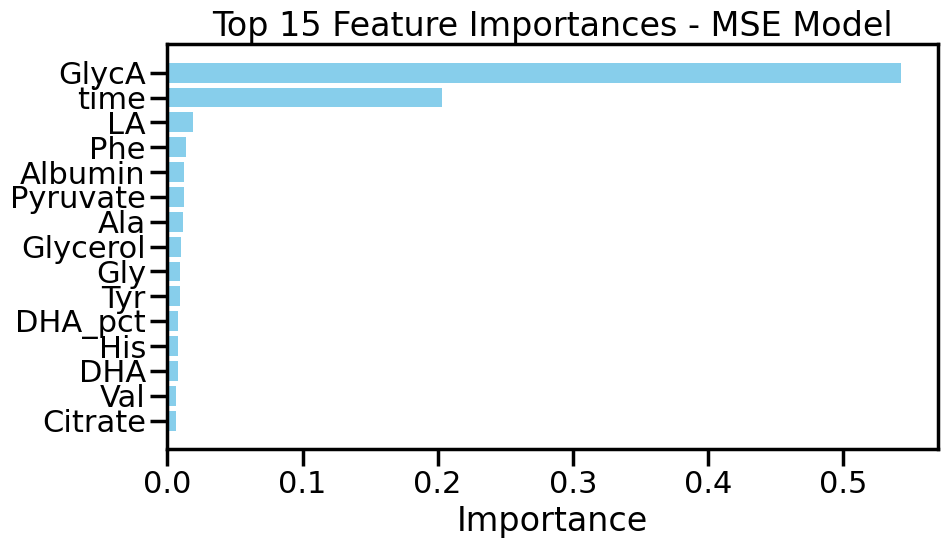

Generating SHAP beeswarm plot for MSE Model...
[OK] SHAP beeswarm saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/shap_beeswarm_only_metabo_MSE_Model.png
[OK] SHAP long-format CSV saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/shap_long_only_metabo_MSE_Model.csv
SHAP beeswarm plot saved for MSE Model
---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:900: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
INFO     [merf.py:307] Training GLL is 546.3904127772881 at iteration 1.
INFO     [merf.py:307] Training GLL is 580.3351759758491 at iteration 2.
INFO     [merf.py:307] Training GLL is 546.8895241122924 at iteration 3.
INFO     [merf.py:307] Training GLL is 525.9808058225786 at iteration 4.
INFO     [merf.py:307] Training GLL is 495.2476303956818 at iteration 5.
INFO     [merf.py:307] Training GLL is 481.03197237166756 at iteration 6.
INFO     [merf.py:307] Training GLL is 471.3060031663432 at iteration 7.
INF

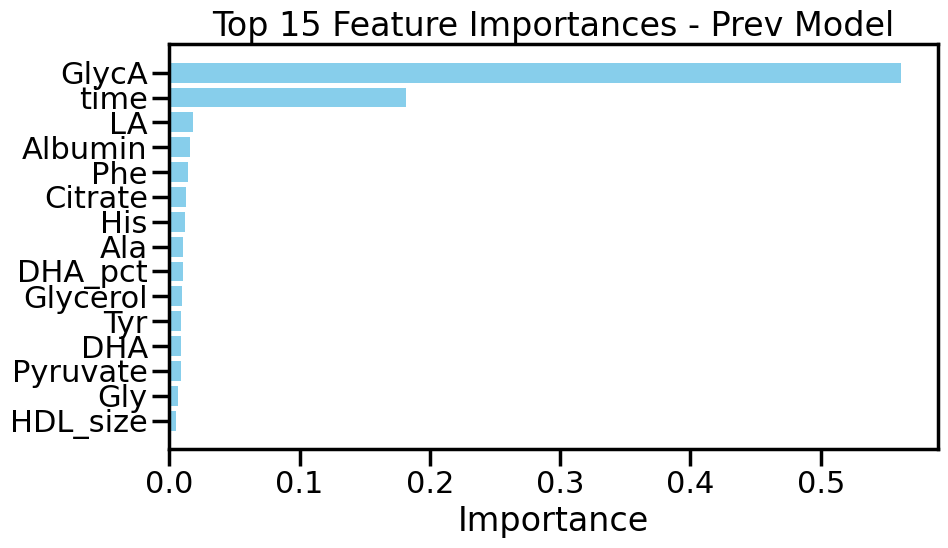

Generating SHAP beeswarm plot for Prev Model...


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 629.5800082753091 at iteration 1.


[OK] SHAP beeswarm saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/shap_beeswarm_only_metabo_Prev_Model.png
[OK] SHAP long-format CSV saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/shap_long_only_metabo_Prev_Model.csv
SHAP beeswarm plot saved for Prev Model
---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 658.7123177225183 at iteration 2.


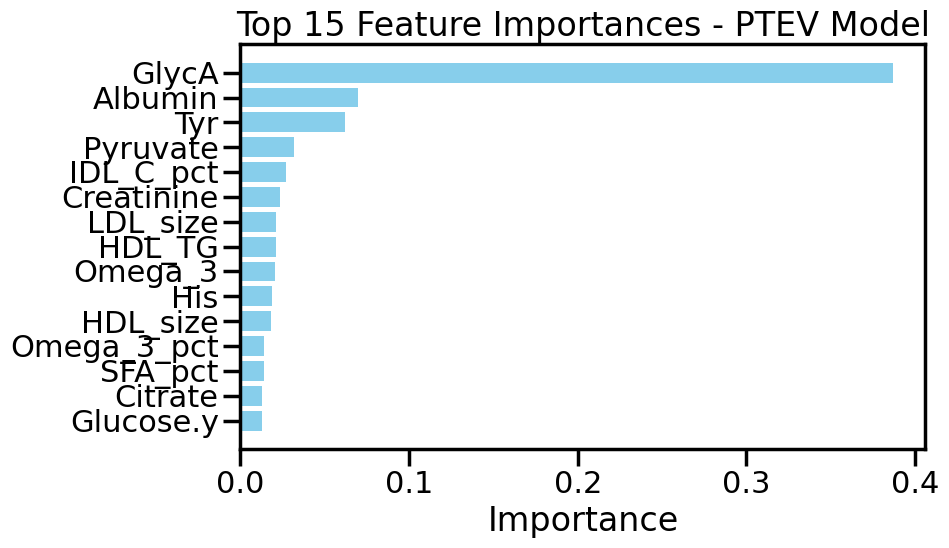

Generating SHAP beeswarm plot for PTEV Model...
[OK] SHAP beeswarm saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/shap_beeswarm_only_metabo_PTEV_Model.png
[OK] SHAP long-format CSV saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/shap_long_only_metabo_PTEV_Model.csv
SHAP beeswarm plot saved for PTEV Model
---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 530.9091488462635 at iteration 1.
INFO     [merf.py:307] Training GLL is 563.5835002252803 at iteration 2.
INFO     [merf.py:307] Training GLL is 519.0735813398177 at iteration 3.
INFO     [merf.py:307] Training GLL is 515.2400842855506 at iteration 4.
INFO     [merf.py:307] Training GLL is 486.32675819828415 at iteration 5.
INFO     [merf.py:307] Training GLL is 478.6948587731692 at iteration 6.
INFO     [merf.py:307] Training GLL is 464.4306658010519 at iteration 7.
INFO     [merf.py:307] Training GLL is 471.89711751266145 at iteration 8.
INFO     [merf.py:307] Training GLL is 459.81119071449353 at iteration 9.
INFO     [merf.py:307] Training GLL is 458.7729608494331 at iteration 10.


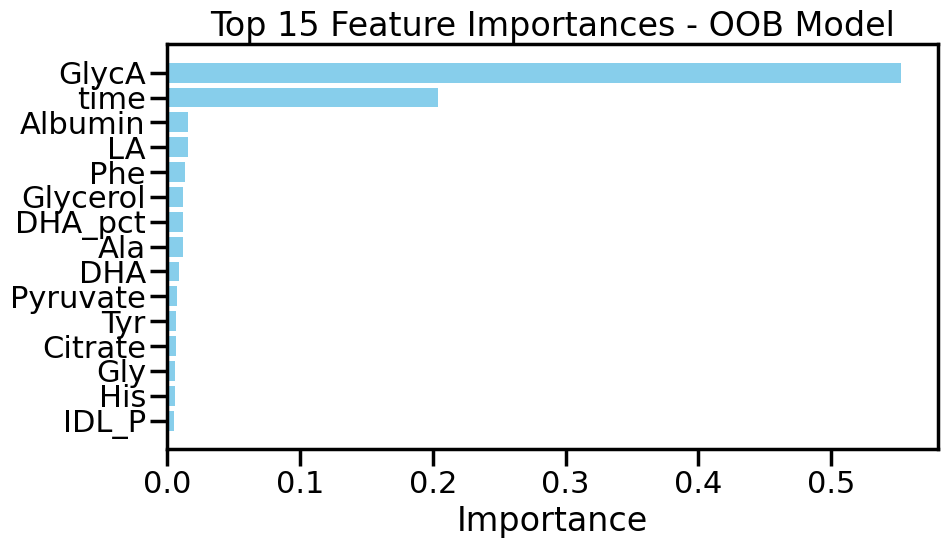

Generating SHAP beeswarm plot for OOB Model...
[OK] SHAP beeswarm saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/shap_beeswarm_only_metabo_OOB_Model.png
[OK] SHAP long-format CSV saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/shap_long_only_metabo_OOB_Model.csv
SHAP beeswarm plot saved for OOB Model


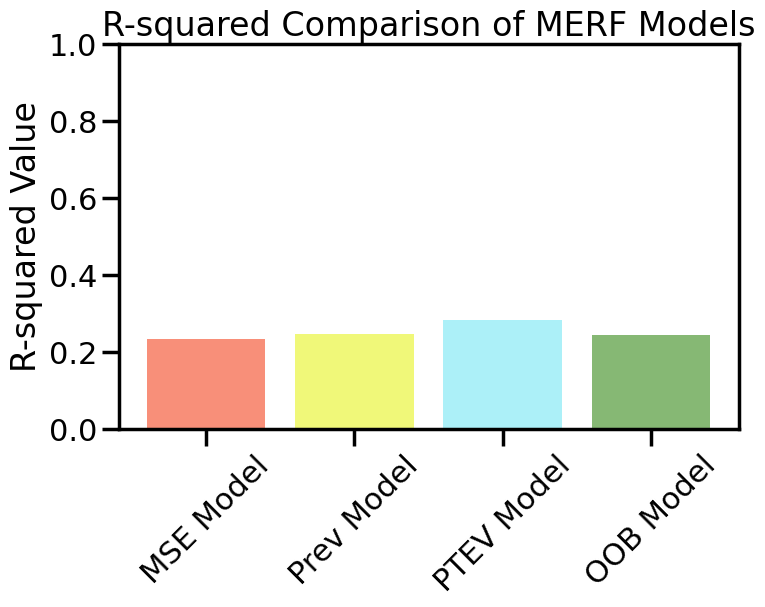

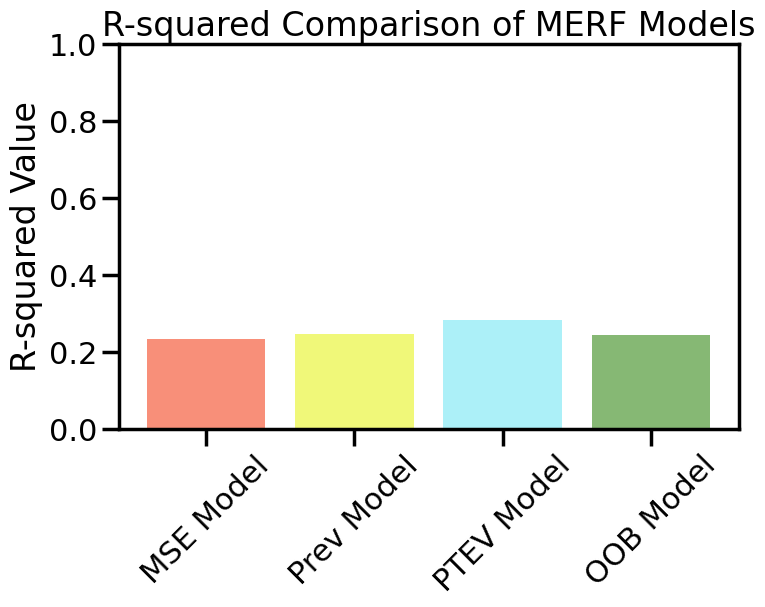

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 650.0586348692156 at iteration 1.


Best model: PTEV Model with R-squared: 0.2834
Generating detailed SHAP analysis for best model: PTEV Model


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 653.5764323177527 at iteration 2.


[OK] SHAP beeswarm saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/shap_beeswarm_only_metabo_BEST_PTEV_Model.png
[OK] SHAP long-format CSV saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/shap_long_only_metabo_BEST_PTEV_Model.csv
Best model SHAP analysis completed for PTEV Model
R-squared values: {'MSE Model': 0.23276943736981015, 'Prev Model': 0.2461661174524068, 'PTEV Model': 0.28339898675935127, 'OOB Model': 0.2442789564850668}
Results DataFrame:
          Model  y_hat_new  R_squared  \
0    MSE Model  33.278796   0.232769   
1    MSE Model  33.862965   0.232769   
2    MSE Model  35.477219   0.232769   
3    MSE Model  35.081932   0.232769   
4    MSE Model  33.070896   0.232769   
..         ...        ...        ...   
347  OOB Model  33.103841   0.244279   
348  OOB Model  30.770694   0.244279   
349  OOB Model

In [15]:
column_sets = {
    #"basic": basic,
    #"meta_keep": meta_keep,
    #"only_grs": only_grs,
    #"only_taxa": only_taxa,
    #"only_micom": only_micom,
    #"only_pathway": only_pathway,
    "only_metabo" : only_metabo,
    #"only_all" : all_col
}
# Loop through each column set and create DATA
for key, columns in column_sets.items():
    DATA = long[columns]
    print(f"Subset for {key} created with shape: {DATA.shape}")
    OUT = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/{key}_long.csv"
    output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/"
    r2_out =  f"{key}_long_r2.pdf"
    r2_adj_out = f"{key}_long_r2_adj.pdf"
    feature_imp_out = f"{key}_long_ft_imp.pdf"
    results_filename = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/{key}_long.csv"

    # Create train and test sets for the current subset
    train_set = DATA[DATA[ID_VAR].isin(train_names)]  # Select rows where ID_VAR is in train_names
    test_set = DATA[DATA[ID_VAR].isin(test_names)]    # Select rows where ID_VAR is in test_names

    # Ensure clusters_train and clusters_test are pandas Series
    clusters_train = pd.Series(train_set[ID_VAR])  # Convert to pandas Series
    clusters_test = pd.Series(test_set[ID_VAR])    # Convert to pandas Series

    # Proceed with MERF analysis for the current subset
    print(f"---------- Select predictors for training set {key} ----------")
    X = train_set.drop([BMI_VAR, ID_VAR], axis=1)
    Y = train_set[BMI_VAR].to_numpy()  # Convert Y to numeric array
    Z = np.ones((train_set.shape[0], 1))  # Create random effects matrix with ones

    # Check lengths before fitting
    print(f"Length of X: {len(X)}, Length of clusters_train: {len(clusters_train)}, Length of Y: {len(Y)}")
    assert len(X) == len(clusters_train), "Length of X does not match length of clusters_train"
    assert len(X) == len(Y), "Length of X does not match length of Y"
    print("Final columns after drop:", X.columns.to_list())
    print("X train values:", train_set[BMI_VAR])

    print("---------- Select predictors for test set ----------")
    X_new = test_set.drop([BMI_VAR, ID_VAR], axis=1)
    X_new = X_new[X.columns]  # Reorder and select columns to match training set
    X_new = X_new.astype(X.dtypes)  # Ensure data types match
    Y_new = test_set[BMI_VAR].to_numpy()  # Convert Y to numeric array
    clusters_new = pd.Series(test_set[ID_VAR])  # Convert to pandas Series
    Z_new = np.ones((len(X_new), 1))  # Create random effects matrix with ones
    time_new = test_set[TIME_VAR].astype(float).to_numpy()  # Convert time values to numeric arrayo numeric array

    # Hyperparameters to tune
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None],
        'min_samples_split': [0.05, 0.1, 0.15],
        'max_iter': [2, 10],
        'n_splits': [3, 5, 10] #cross-validation
    }
    # Create training features
    # X = train_set.drop(columns=columns_to_drop, errors='ignore')
    y = train_set[[BMI_VAR]]
    y = y[BMI_VAR].to_numpy() # Convert Y to numeric array
    clusters = train_set[ID_VAR].to_numpy() # Get ID variables
    z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones

    best_score = float('inf')
    best_params = {}
    results = []  # Initialize a list to store the results of each iteration

    # Loop through all possible combinations of parameters
    total_combinations = len(list(itertools.product(*param_grid.values())))  # Calculate total combinations
    for idx, params in enumerate(itertools.product(*param_grid.values())):
        n_estimators, max_depth, min_samples_split, max_iter, n_splits = params
        
        # Print progress
        progress_percentage = (idx + 1) / total_combinations * 100
        print(f"Combination: {params}\n")
        print(f"Progress: {progress_percentage:.2f}% completed\n")
        scores, prev, ptev, oob_scores = [], [], [], []  # Initialize lists for scores

        # K-fold cross-validation with variable n_splits
        kf = KFold(n_splits=n_splits)
        for train_index, test_index in kf.split(X):
            #print("Train indices:", train_index)
            #print("Test indices:", test_index)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Use .iloc for row selection
            y_train, y_test = y[train_index], y[test_index]
            clusters_train, clusters_test = clusters[train_index], pd.Series(clusters[test_index])
            z_train, z_test = z[train_index], z[test_index]

            print("Length of clusters_train:", len(clusters_train))
            print("Length of clusters_test:", len(clusters_test))
            #print("Train indices:", train_index)
            #print("Test indices:", test_index)

            model = MERF(
                    # Specify the fixed effects model as a Random Forest Regressor
                fixed_effects_model=RandomForestRegressor(
                    n_estimators=n_estimators,  # Number of trees in the forest
                    max_depth=max_depth,  # Maximum depth of each tree
                    min_samples_split=min_samples_split,  # Minimum samples required to split an internal node
                    n_jobs=1,  # Number of jobs to run in parallel
                    oob_score=True  # Whether to use out-of-bag samples to estimate the R^2 on unseen data
                    ),
                    # Generalized Linear Model (GLM) early stopping threshold
                gll_early_stop_threshold=None,  # No early stopping threshold set
                    # Maximum number of iterations for the MERF algorithm
                max_iterations=max_iter  # Maximum number of iterations to run the MERF algorithm
                )
            model.fit(X_train.select_dtypes(include=[np.number]), z_train, pd.Series(clusters_train), y_train)
            y_pred = model.predict(X_test, z_test, clusters_test)
            scores.append(np.mean((y_pred - y_test) ** 2)) # MSE
            
            # Calculate ptev and prev
            total_variance = np.var(y_test)
            random_effect_variance = np.var(y_test - y_pred)
            fixed_effect_variance = total_variance - random_effect_variance

            ptev.append(np.mean(fixed_effect_variance / total_variance if total_variance > 0 else 0))
            prev.append(np.mean(random_effect_variance / total_variance if total_variance > 0 else 0))

            # Calculate OOB score
            forest = model.trained_fe_model
            oob_score = round(forest.oob_score_ * 100, 1)  # percent variation
            oob_scores.append(oob_score)

            # Print ptev, prev, and OOB score for the current iteration
            print(f"Combination, ptev: {np.mean(ptev):.4f}, prev: {np.mean(prev):.4f}, OOB Score: {oob_score:.4f}")

        # Calculate the mean of the scores for the current combination of parameters
        mean_score = np.mean(scores)
        if mean_score < best_score:
            best_score = mean_score
            best_params = params

        # Append the results of the current iteration to the results list
        result_dict = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'max_iter': max_iter,
            'n_splits': n_splits,
            'mean_mse_score': mean_score,
            'mean_prev': np.mean(prev),
            'mean_ptev': np.mean(ptev),
            'oob_score': np.mean(oob_scores)
        }
        results.append(result_dict)

    print("Best parameters:", best_params)
    print("Best score:", best_score)

    # Convert the results list to a DataFrame and save it to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv(OUT, index=False)

    print("---------- Run MERF models ----------")
    r2_values, results_df = run_merf_analysis2(
        X, Y, Z, clusters,
        X_new, Y_new, Z_new, clusters_new,
        results_df,
        output_dir, r2_out, r2_adj_out, feature_imp_out, results_filename, time_new, include_shap=True, key=key)

    # Print the R-squared values and the results DataFrame
    print("R-squared values:", r2_values)
    print("Results DataFrame:\n", results_df)
    print("---------- Done saving Merf output ----------")